In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(ggplot2)
library(pheatmap)
library(RColorBrewer)
library(GenomicRanges)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following object i

In [3]:
lmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", 
                  sep = "\t", row.names = 1)

In [4]:
### Add brain region color
cols <- read.csv("/projects//ps-renlab2/y2xie/projects/BICAN/ref/yel_Science2023_supp/brain_dissection_anno.xls", sep = "\t")
col1 <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.color) %>% unlist
names(col1) <- cols %>% dplyr::select(Brain.structure.name, Brain.structure.color) %>% distinct %>% dplyr::select(Brain.structure.name) %>% unlist

col2 <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region.color) %>% unlist
names(col2) <- cols %>% dplyr::select(Brain.region, Brain.region.color) %>% distinct %>% dplyr::select(Brain.region) %>% unlist

In [5]:
cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [6]:
bcol <- read.csv("../Figure/superterm.color", row.names = 1, sep = "\t")
ccol3 <- bcol$bcol
names(ccol3) <- rownames(bcol)

dcol <- c("#8ecae6", "#00acdf", "#006699")
names(dcol) <- unique(lmeta$donor)

tcol <- c("#2EA7E0", "#956134")
names(tcol) <- c("H3K27ac", "H3K27me3")

In [7]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

In [8]:
glut <- lmeta %>% filter(structure == "Cortex", class == "Glut") %>% select(subclass_corrected) %>% unique %>%
unlist %>% as.character
gaba <- lmeta %>% filter(structure == "Cortex", class == "GABA") %>% select(subclass_corrected) %>% unique %>%
unlist %>% as.character

In [9]:
abc <- read.table("../08.conns/plot/broad_abc_filtcelltype_select_conns.txt", sep = "\t", row.names = 1, header = T)

In [68]:
mmg <- qs::qread("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.qs")
mmg <- subset(mmg, subset = keep == 1)
mmg

An object of class Seurat 
38369 features across 751077 samples within 1 assay 
Active assay: RNA (38369 features, 5572 variable features)
 3 layers present: data, counts, scale.data
 9 dimensional reductions calculated: pca, harmony, umap, k27ac_umap, k27me3_umap, k27ac_spectral_harmony, k27ac_umap_new, k27me3_spectral_harmony, k27me3_umap_new

In [242]:
exprr <- AggregateExpression(mmg, group.by = c("donor", "subclass_corrected"))
designs = stringr::str_split_fixed(colnames(exprr$RNA), n = 2, pattern = "_") %>% 
as.data.frame %>% setNames(c("sample", "group"))
rownames(designs) <- colnames(exprr$RNA)

## Read AP axis

In [201]:
### regional blocks information provided by Natalie and Tati:
border <- read.csv("Miniatlas_AP-axis_v1.csv", header = T) %>%
setNames(c("division", "region", "image", "range", "start", "group", "donor", "tregion", "plate_range", "local_ap"))

border$Miniatlas <- border$cregion <- border$region
border[border$region == "DFC (A46)",]$Miniatlas <- "A46"
border[border$region == 'PPHC (TH, TL)',]$Miniatlas <- "TH-TL"
border[border$region == 'PSC (A19)',]$Miniatlas <- "A19"
border[border$region == 'EC (MEC)',]$Miniatlas <- "MEC"
border[border$region == 'M1C (A4)',]$Miniatlas <- "M1C"
border[border$region == 'MTC (A21)',]$Miniatlas <- "MTG"
border[border$region == 'ITC (A20)',]$Miniatlas <- "ITG"
border[border$region %in% c('SPC (A5)','SPC (A7)'),]$Miniatlas <- "A5-A7"
border[border$region %in% c("CBL (CBLA, CBLP)", "CBLA", "CBLP"),]$Miniatlas <- "CBL"
border[border$region %in% c('CBV (VeA, VePo, VeF)', 'VeA', 'VeF', 'VePo'),]$Miniatlas <- "CBV"

border[border$region == "DFC (A46)",]$cregion <- "A46"
border[border$region == 'PPHC (TH, TL)',]$cregion <- "PPHC"
border[border$region == 'PSC (A19)',]$cregion <- "PSC"
border[border$region == 'EC (MEC)',]$cregion <- "MEC"
border[border$region == 'M1C (A4)',]$cregion <- "M1C"
border[border$region == 'MTC (A21)',]$cregion <- "MTC"
border[border$region == 'ITC (A20)',]$cregion <- "ITC"
border[border$region %in% c('SPC (A5)','SPC (A7)'),]$cregion <- "SPC"
border[border$region %in% c("CBL (CBLA, CBLP)", "CBLA", "CBLP"),]$cregion <- "CBL"
border[border$region %in% c('CBV (VeA, VePo, VeF)', 'VeA', 'VeF', 'VePo'),]$cregion <- "CBV"

## Regional difference in cortex

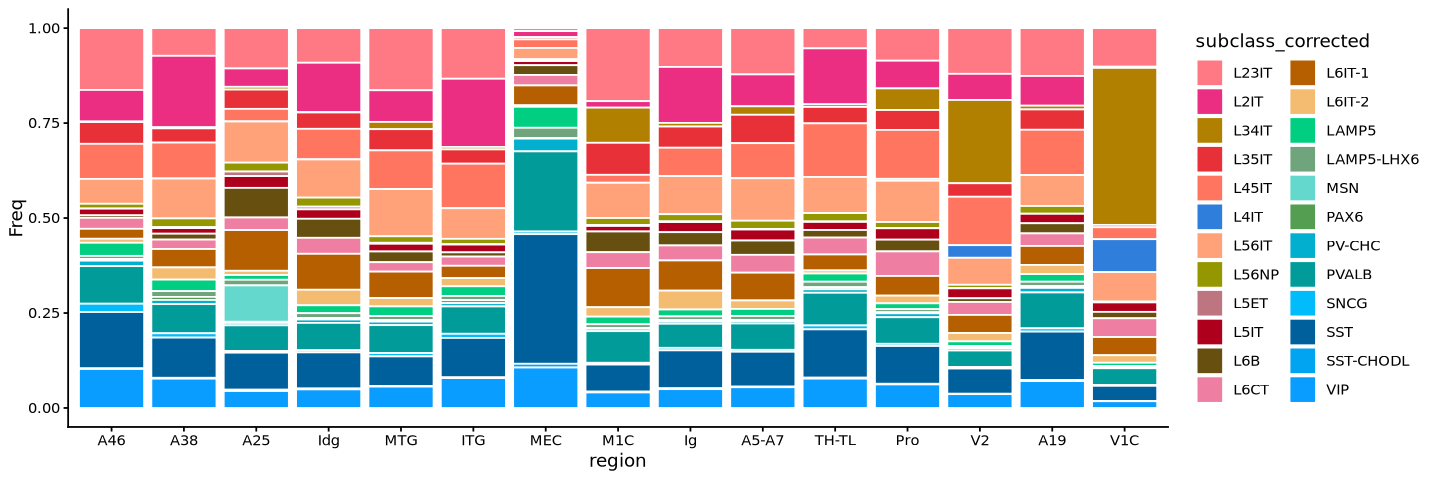

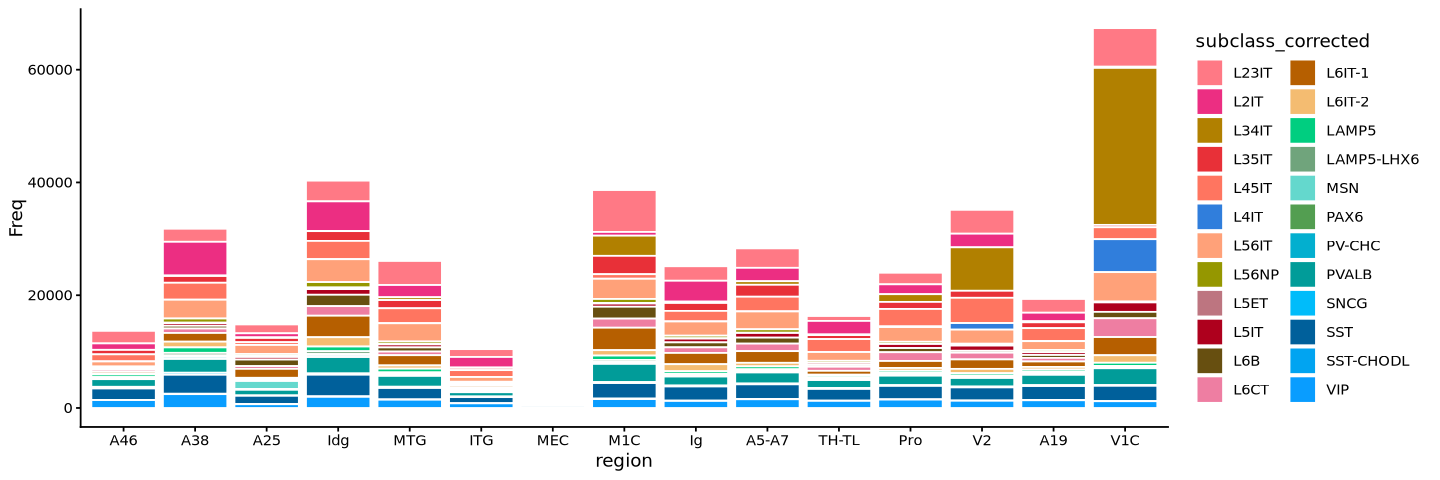

In [13]:
qregion <- border %>% filter(group <= 16) %>% arrange(group) %>%
select(Miniatlas) %>% unlist %>% unique

tmp <- lmeta %>% filter(structure == "Cortex") %>%
select(subclass_corrected, region) %>% table

qcell <- unique(lmeta[lmeta$structure == "Cortex" & lmeta$class != "NonN" & lmeta$keep == 1, ]$subclass_corrected)
qcell <- setdiff(qcell, "CBGA")

tcomp <- lmeta %>% filter(structure == "Cortex", 
                          region %in% qregion, 
                          subclass_corrected %in% qcell) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()
tcomp$group <- border[match(tcomp$region, border$Miniatlas), ]$group %>% as.integer

options(repr.plot.width = 12, repr.plot.height = 4)

tcomp %>% mutate(region = factor(region, levels = qregion)) %>%
ggplot(aes(x = region, y = Freq, fill = subclass_corrected)) + 
geom_col(position = "fill", color = "white") +
theme_classic() + 
scale_fill_manual(values = ccol2)

tcomp %>% mutate(region = factor(region, levels = qregion)) %>%
ggplot(aes(x = region, y = Freq, fill = subclass_corrected)) + 
geom_col(position = "stack", color = "white") +
theme_classic() + 
scale_fill_manual(values = ccol2)

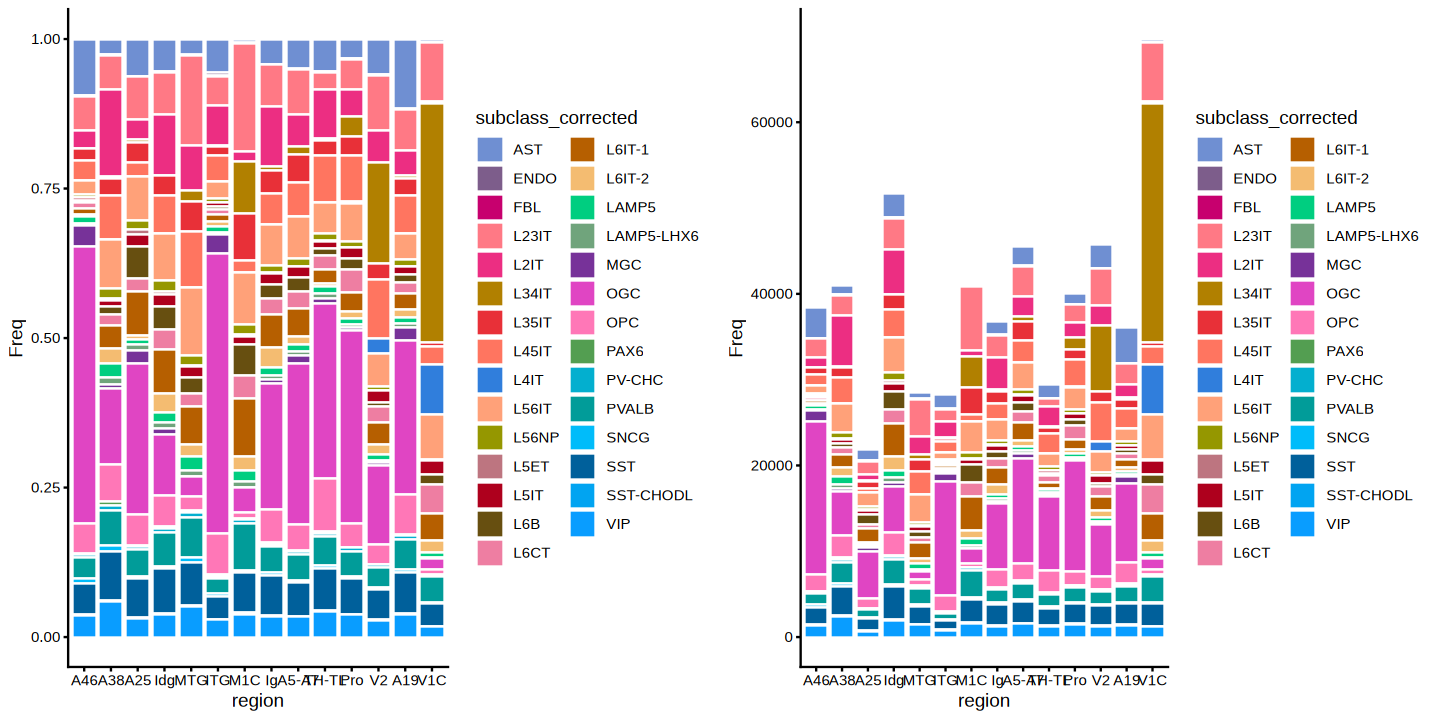

In [1518]:
tcomp <- lmeta %>% filter(structure == "Cortex", 
                          region %in% qregion, 
                          subclass_corrected %in% qclass) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()
tcomp$group <- border[match(tcomp$region, border$Miniatlas), ]$group %>% as.integer

t1 <- tcomp %>% mutate(region = factor(region, levels = qregion)) %>%
ggplot(aes(x = region, y = Freq, fill = subclass_corrected)) + 
geom_col(position = "fill", color = "white") +
theme_classic() + 
scale_fill_manual(values = ccol2)

t2 <- tcomp %>% mutate(region = factor(region, levels = qregion)) %>%
ggplot(aes(x = region, y = Freq, fill = subclass_corrected)) + 
geom_col(position = "stack", color = "white") +
theme_classic() + 
scale_fill_manual(values = ccol2)

fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)
options(repr.plot.width = 12, repr.plot.height = 6)
fig1

## Estimate overall regional heterogenity using LISI

In [84]:
### subsample 100 cells per region per cell type per donor?
set.seed(921)
qcell <- list()
for (ct in qclass){
    for (f in qregion){
        for (d in unique(mmg$donor)){
            tmp <- mmg@meta.data %>% filter(subclass_corrected == ct, region == f, donor == d) %>% rownames
            if (length(tmp) >= 100){
                tmp <- sample(tmp, size = 100, replace = F)
            }
            qcell[[paste0(ct, ":", f, ":", d)]] <- tmp
        }
    }
}

In [ ]:
qcell <- list()
for (f in qregion){
    for (d in unique(mmg$donor)){
        tmp <- mmg@meta.data %>% filter(subclass_corrected == ct, region == f, donor == d) %>% rownames
        if (length(tmp) >= 200){
            tmp <- sample(tmp, size = 200, replace = F)
        }
        qcell[[paste0(ct, ":", f, ":", d)]] <- tmp
    }
}

In [85]:
tmp <- subset(mmg, cells = unlist(qcell))
tmp$group <- paste0(tmp$subclass_corrected, ":", tmp$region, ":", tmp$donor)
rexpr <- ArcXPM(tmp[["RNA"]]$counts, meta = tmp@meta.data, group.by = 'group', method = "RPKM", 
                         gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")

sparsity: 0.412252738641804
coarse dgTMatrix into Matrix.
check readSums:  1216 
check obj_mtx_collapse:  1216 


In [101]:
mmg$group <- paste0(mmg$subclass_corrected, ":", mmg$region, ":", mmg$donor)
rexpr <- ArcXPM(mmg[["RNA"]]$counts, meta = mmg@meta.data, group.by = 'group', method = "RPKM", 
                gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")

sparsity: 0.47943594575984
coarse dgTMatrix into Matrix.
check readSums:  1329 
check obj_mtx_collapse:  1329 


In [107]:
suppressPackageStartupMessages(library(variancePartition))

ccount <- table(mmg$group) %>% as.data.frame 
design <- stringr::str_split_fixed(colnames(rexpr), pattern = ":", n = 3) %>%
as.data.frame %>% setNames(c("subclass_corrected", "region", "donor"))
rownames(design) <- colnames(rexpr)
design$region <- as.factor(design$region)
design$donor <- as.factor(design$donor)
design$Freq <- ccount[match(rownames(design), ccount$Var1), ]$Freq

head(rexpr, 3)
head(design, 3)

L23IT:A38:Donor4 L35IT:A38:Donor4 L56IT:A38:Donor4 L2IT:A38:Donor4
DDX11L2     0                0                0                0              
MIR1302-2HG 0                0                0                0              
FAM138A     0                0                0                0              
            L6IT-2:A38:Donor4 L45IT:A38:Donor4 L56NP:A38:Donor4 VIP:A38:Donor4
DDX11L2     0                 0                0                0             
MIR1302-2HG 0                 0                0                0             
FAM138A     0                 0                0                0             
            L6CT:A38:Donor4 SST:A38:Donor4 ⋯ PAX6:Pro:Donor2 MGC:Pro:Donor1
DDX11L2     0               0              ⋯ 0               0             
MIR1302-2HG 0               0              ⋯ 0               0             
FAM138A     0               0              ⋯ 0               0             
            ENDO:Pro:Donor2 FBL:Pro:Donor1 SNCG:Pro:Donor1 SST-CHODL:Pro:Donor1
DDX11L2     0               0              0               0                   
MIR1302-2HG 0               0              0               0                   
FAM138A     0               0              0               0                   
            L5ET:Pro:Donor1 IMMUNE:Pro:Donor1 L4IT:Pro:Donor2 IMMUNE:Pro:Donor2
DDX11L2     0               0                 0               0                
MIR1302-2HG 0               0                 0               0                
FAM138A     0               0                 0               0

subclass_corrected region donor  Freq
L23IT:A38:Donor4 L23IT              A38    Donor4 1401
L35IT:A38:Donor4 L35IT              A38    Donor4  468
L56IT:A38:Donor4 L56IT              A38    Donor4 1369

In [117]:
### split conditions by subclass?
ct <- "L23IT"
qrexpr <- rexpr[,grep(ct, colnames(rexpr))]
qrexpr <- qrexpr[rowMeans(qrexpr) > 1, ] 
qdesign <- design[grep(ct, rownames(design)),]

form <- ~ Freq + (1|region) + (1|donor)
varPart <- fitExtractVarPartModel(qrexpr, form, qdesign)
vp <- sortCols(varPart)

Warning message in .fitExtractVarPartModel(exprObj, formula, data, REML = REML, :
“Model failed for 26 responses.
  See errors with attr(., 'errors')”


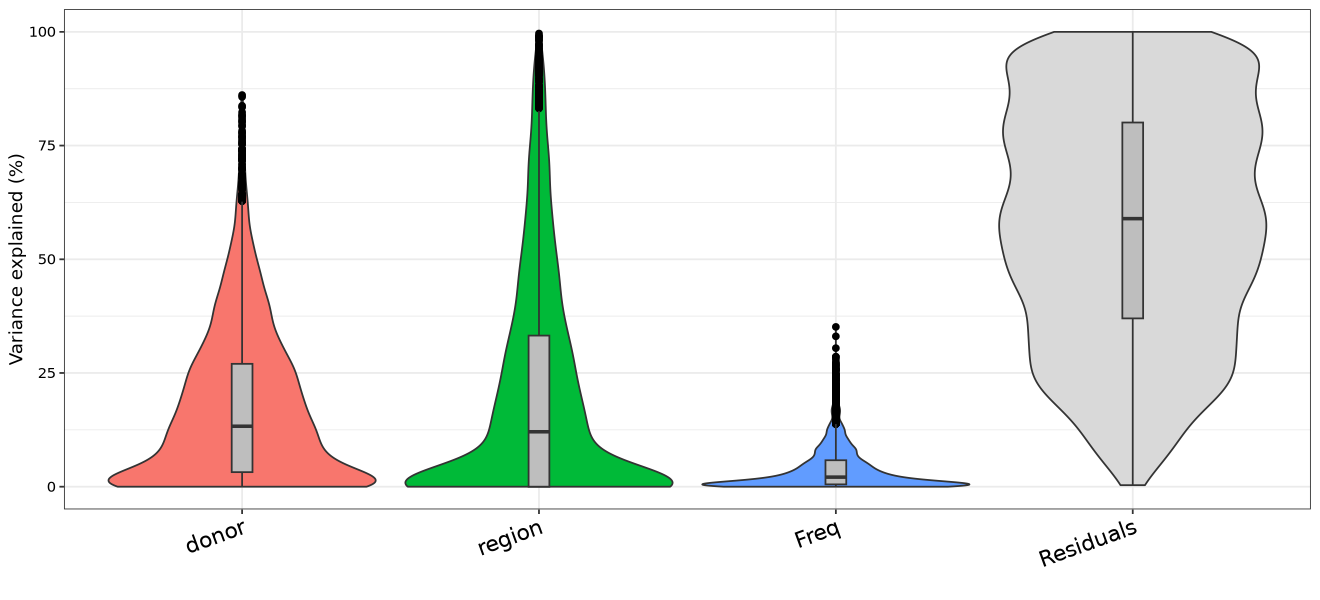

In [118]:
plotVarPart(vp) 

In [308]:
flist <- list()
for (file in list.files("regional_het/", pattern = "MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722.*.lisi")){
    ### this is run already on dono harmonized data, Also sample to make sure region + donor balanced (200 cells)
    fname <- gsub("MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_([^\\.]+).lisi", "\\1", file)
    flist[[fname]] <- read.table(paste0("regional_het/", file)) %>% mutate(celltype = fname)
}

Picking joint bandwidth of 0.222

Picking joint bandwidth of 0.0639

Picking joint bandwidth of 0.036



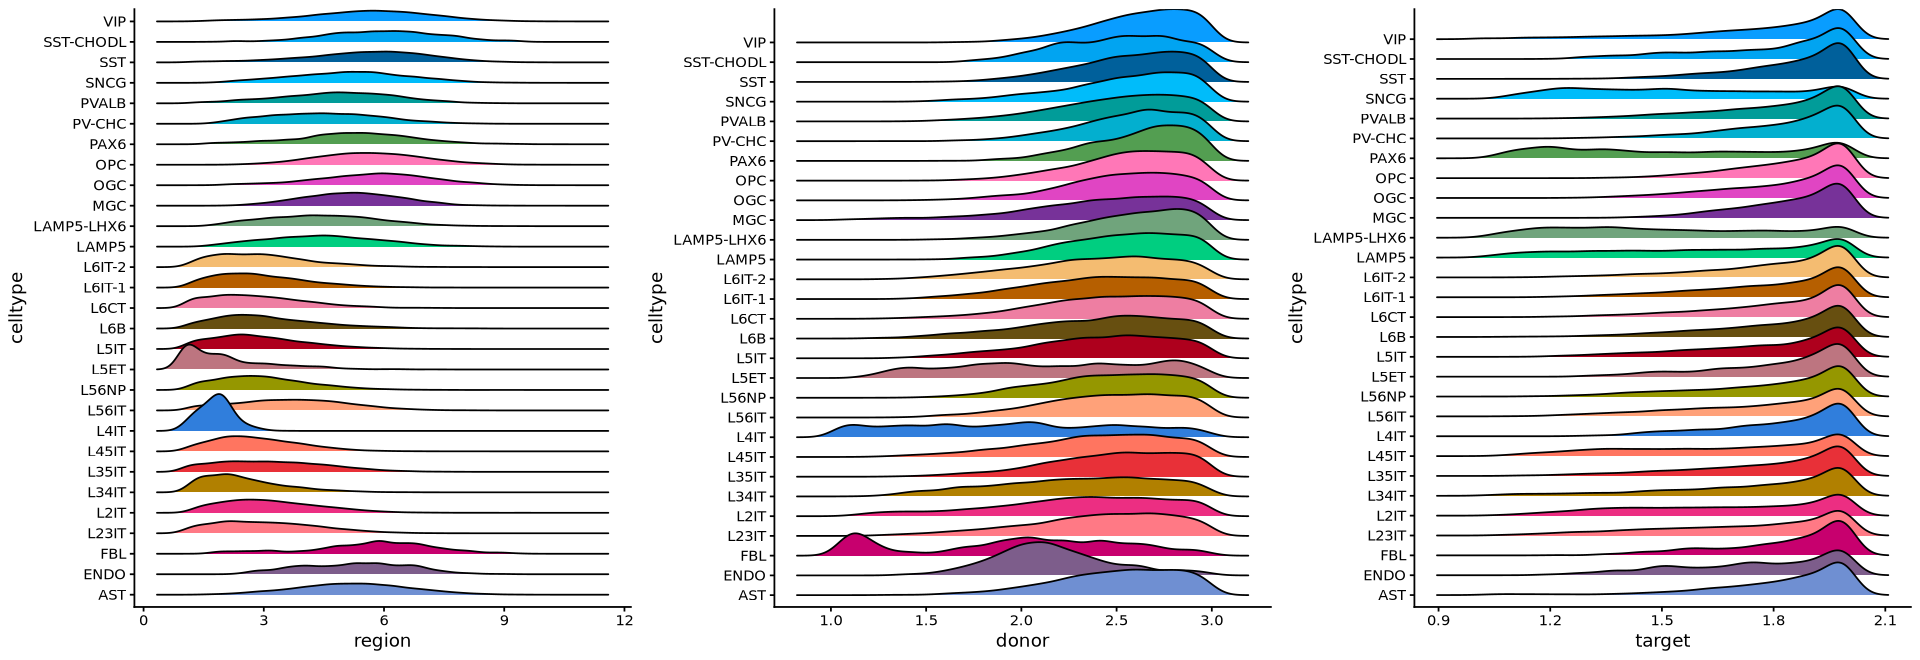

In [288]:
library(ggridges)

t1 <- do.call(rbind, flist) %>% filter(celltype %in% qclass) %>%
ggplot(aes(x = region, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + NoLegend()

t2 <- do.call(rbind, flist) %>% filter(celltype %in% qclass) %>%
ggplot(aes(x = donor, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + NoLegend()

t3 <- do.call(rbind, flist) %>% filter(celltype %in% qclass) %>%
ggplot(aes(x = target, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + NoLegend()

options(repr.plot.width = 16, repr.plot.height = 5.5)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

Picking joint bandwidth of 0.222

Picking joint bandwidth of 0.26

Picking joint bandwidth of 0.26



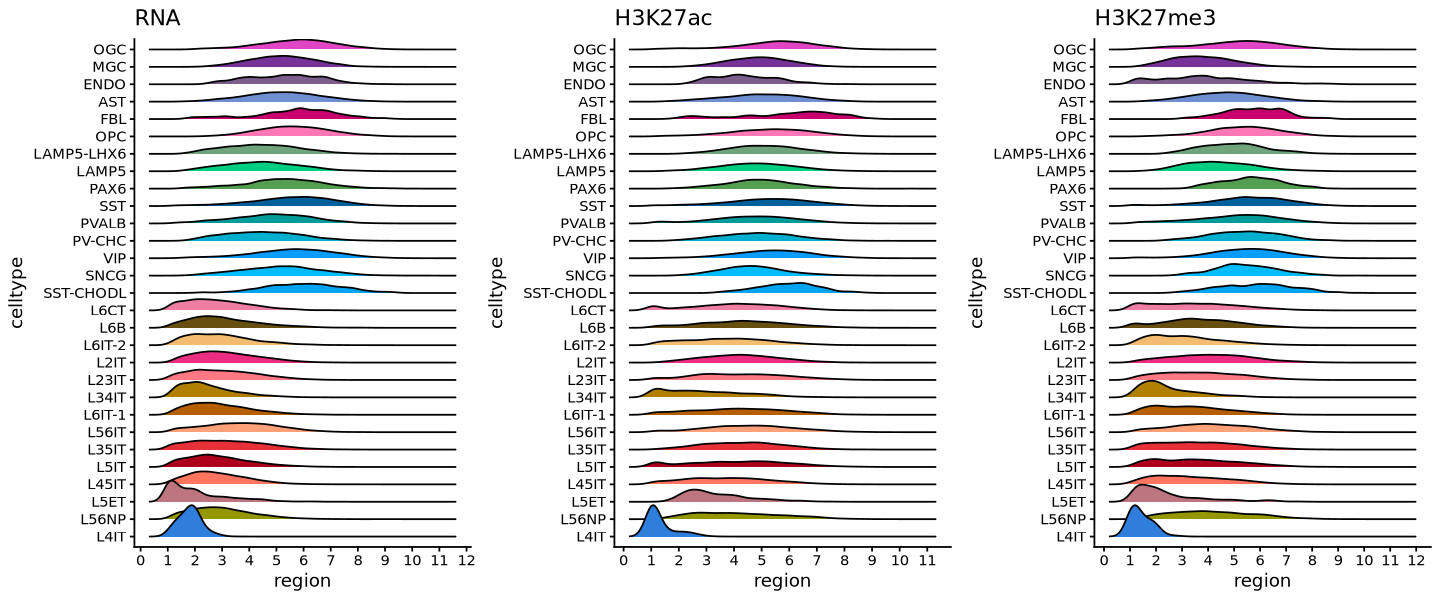

In [310]:
### H3K27ac and H3K27me3
flist2 <- flist3 <- list()
for (file in list.files("regional_het/", pattern = "MiniAtlas_H3K27ac_merged_dual_filt_clean_corrected_250529.*.lisi")){
    ### this is run already on dono harmonized data! Also sample to make sure region + donor balanced (200 cells)
    fname <- gsub("MiniAtlas_H3K27ac_merged_dual_filt_clean_corrected_250529_([^\\.]+).lisi", "\\1", file)
    flist2[[fname]] <- read.table(paste0("regional_het/", file)) %>% mutate(celltype = fname)
    flist3[[fname]] <- read.table(paste0("regional_het/MiniAtlas_H3K27me3_merged_dual_filt_clean_corrected_250529_", fname, '.lisi')) %>% mutate(celltype = fname)
}

t1 <- do.call(rbind, flist) %>% filter(celltype %in% qclass) %>%
mutate(celltype = factor(celltype, levels = rev(corder))) %>%
ggplot(aes(x = region, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("RNA") + 
scale_x_continuous(breaks = seq(0, 14, 1)) + 
NoLegend()

t2 <- do.call(rbind, flist2) %>% filter(celltype %in% qclass) %>%
mutate(celltype = factor(celltype, levels = rev(corder))) %>%
ggplot(aes(x = region, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27ac") + 
scale_x_continuous(breaks = seq(0, 14, 1)) + 
NoLegend()

t3 <- do.call(rbind, flist3) %>% filter(celltype %in% qclass) %>%
mutate(celltype = factor(celltype, levels = rev(corder))) %>%
ggplot(aes(x = region, y = celltype, fill = celltype)) + 
geom_density_ridges() + scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27me3") + 
scale_x_continuous(breaks = seq(0, 14, 1)) + 
NoLegend()

fig1 <- cowplot::plot_grid(t1, t2, t3, ncol = 3)

options(repr.plot.width = 12, repr.plot.height = 5)
fig1

## Regional difference of gene expression in cortex

In [94]:
### we retain region with > 50 cells for diff test 
rvalid <- lmeta %>% select(c(subclass_corrected, region)) %>%
table %>% as.data.frame %>% filter(Freq >= 50)

In [95]:
### use pseudoreplicates of 2 to minimize donor effects (dont care)
### only subset limited cells (500) per pseudoreplicate per region for testing
rlist <- list()
for (f in qclass){
    tmp <- list()
    i = 1
    for (file in list.files(paste0("region_DEG/", f))){
        fname <- gsub(".*.__edgeR_([^_]+)_vs_all.tsv", "\\1", file)
        if ((fname %in% qregion) & (fname %in% as.character(rvalid[rvalid$subclass_corrected == f,]$region))){
            tmp[[i]] <- read.table(paste0("region_DEG/", f, "/", file), header = T, row.names = 1) %>% 
            mutate(region = fname) %>% tibble::rownames_to_column("gene")
            i = i + 1
        }
    }
    rlist[[f]] <- do.call(rbind, tmp)
}

### for f in region_DEG/*; do fname=`basename $f`; nohup Rscript scripts/region_edgeR.R ../04.clustering/02.RNA/04.final_cluster_250722/02.seurat_object/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_${fname}_RNA.qs ${f}/${fname} & done

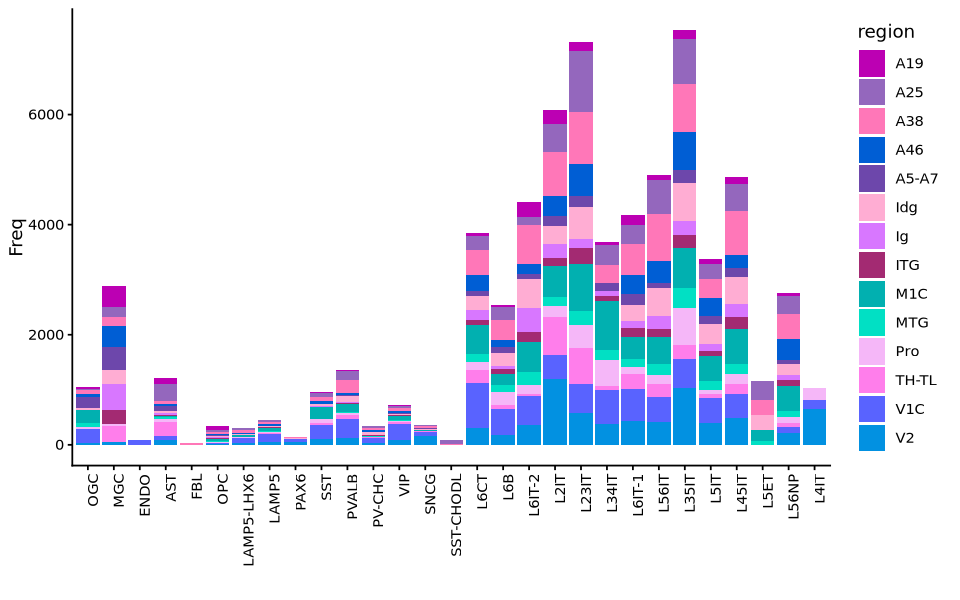

In [256]:
t1 <- do.call(rbind, lapply(rlist, function(x) x %>%
filter(FDR < 0.01, abs(logFC) >= 1) %>%
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
select(direction, region) %>%
table %>% as.data.frame)) %>% filter(direction == "pos") %>%
tibble::rownames_to_column("id") %>%
mutate(celltype = gsub("([^\\.]+).*", "\\1", id)) %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) + 
geom_col(position = "stack") + 
theme_classic() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
xlab("") +
scale_fill_manual(values = col2)

options(repr.plot.width = 8, repr.plot.height = 5)
t1

### Check histone DHR on ATAC cCREs

In [801]:
acvalid <- lmeta %>% filter(target == "H3K27ac") %>%
select(c(subclass_corrected, region)) %>%
table %>% as.data.frame %>% filter(Freq >= 100)

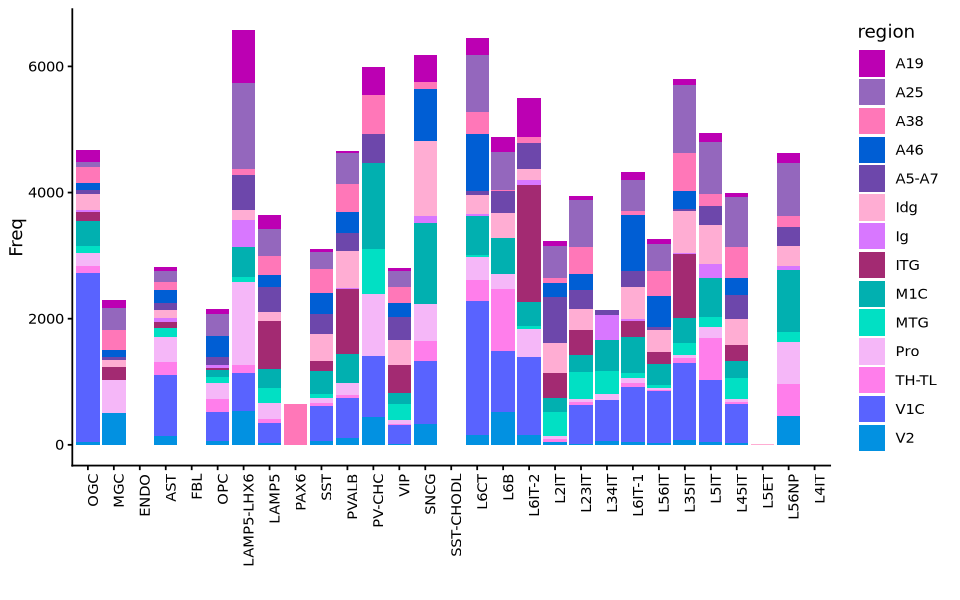

In [280]:
### for H3K27ac / H3K27me3: subset limited cells (500) per region for testing
acvalid <- lmeta %>% filter(target == "H3K27ac") %>%
select(c(subclass_corrected, region)) %>%
table %>% as.data.frame %>% filter(Freq >= 100)

dlist <- list()
for (f in qclass){
    dlist[[f]] <- read.csv(paste0("region_DHR/H3K27ac/", f, '.csv'), header = T) %>% 
    setNames(c("feature", "logFC", "pval", "FDR", "region")) %>%
    filter(region %in% qregion) %>%
    filter(region %in% as.character(acvalid[acvalid$subclass_corrected == f,]$region)) %>%
    mutate(celltype = f)
}

t2 <- do.call(rbind, dlist) %>%
filter(FDR < 0.05, abs(logFC) >= 1) %>%
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
filter(direction == "pos") %>% 
select(region, celltype) %>%
mutate(celltype = factor(celltype, levels = qct)) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = qct)) %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) + 
geom_col(position = "stack") + 
theme_classic() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
xlab("") +
scale_fill_manual(values = col2)

options(repr.plot.width = 8, repr.plot.height = 5)
t2

In [ ]:
mevalid <- lmeta %>% filter(target == "H3K27me3") %>%
select(c(subclass_corrected, region)) %>%
table %>% as.data.frame %>% filter(Freq >= 100)

dlist2 <- list()
for (f in qclass){
    dlist2[[f]] <- read.csv(paste0("region_DHR/H3K27me3/", f, ".csv"), header = T) %>% 
    setNames(c("feature", "logFC", "pval", "FDR", "region")) %>%
    filter(region %in% qregion) %>%
    filter(region %in% as.character(mevalid[mevalid$subclass_corrected == f,]$region)) %>%
    mutate(celltype = f)
}

t3 <- do.call(rbind, dlist2) %>%
filter(FDR < 0.05, abs(logFC) >= 1) %>%
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
filter(direction == "pos") %>% 
mutate(celltype = factor(celltype, levels = qct)) %>%
select(region, celltype) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = qct)) %>%
ggplot(aes(x = celltype, y = Freq, fill = region)) + 
geom_col(position = "stack") + 
theme_classic() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
xlab("") +
scale_fill_manual(values = col2)

## Examples of regional sepcfic genes: L35IT

In [1203]:
qgene <- read.table("../../ref/Glut.receptor") ### maybe...
rpkm1 <- read.table("MiniAtlas_RNA_merged_dual_filt_clean_corrected.subset_region_subclass.rpkm", sep = "\t", check.names = F,
                  row.names = 1, header = T)

In [1451]:
tmp <- read.table("../Figure/FIG4_cortex_cells_regional_DEG.txt", 
                  row.names = 1, header = T, sep = "\t")
tmp <- tmp %>% mutate(celltype = gsub("([^.]+)\\.([^.]+)", "\\1", rownames(tmp)))

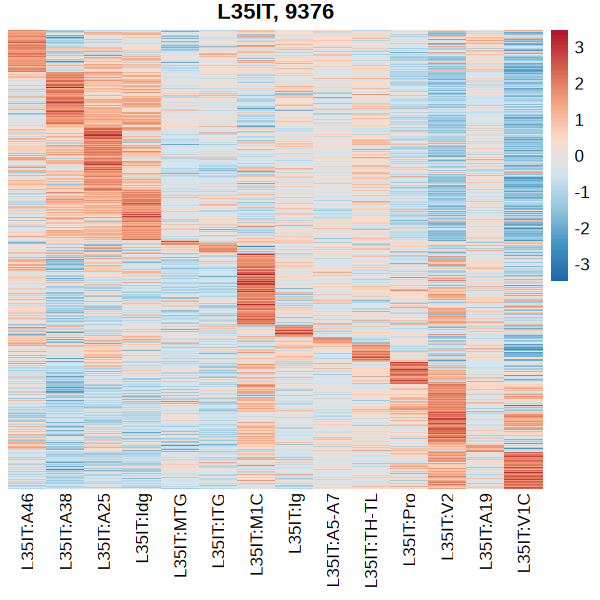

In [1452]:
f <- "L35IT"
qgene <- tmp %>%
filter(celltype == f, FDR < 0.01, abs(logFC) >= 1) %>%
select(gene) %>% unlist %>% as.character 

rmat <- log2(rexpr[qgene, paste0(f, ":", axis_df$region)] + 1)
# rmat <- rmat[rowSums(rmat) >= 1, ]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ] 

options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- smat %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "row", main = paste0(f, ", ", nrow(smat)),
         show_rownames = F, treeheight_row = F, angle_col = 90, border_color = NA,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

In [1463]:
f <- "L35IT"
fterm <- 'regulation of cytosolic calcium ion concentration' #'regulation of monoatomic ion transport'
qgene1 <- flist2[[f]] %>% filter(Description == fterm) %>%
select(geneID) %>% unlist
qgene1 <- stringr::str_split(qgene1, pattern = "\\/") %>% unlist
qgene1

qgene1 <- abc %>% filter(celltype == f, TargetGene %in% qgene1) %>% select(TargetGene) %>% unlist %>% unique
length(qgene1)

[1] "CNGB1"  "GRM1"   "TRPC4"  "TRPC6"  "CAV2"   "CALCB"  "TRPC3"  "GRIA1" 
 [9] "CNR1"   "ATP2B4" "CAV1"   "HTR1B"

[1] 9

### Show ion channel examples

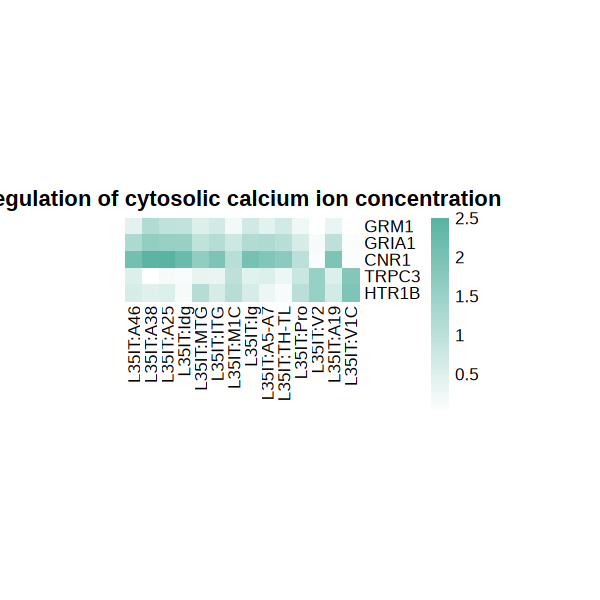

In [1464]:
mtx <- smat[intersect(rownames(smat), qgene1), ]
t1 <- mtx[rowMeans(mtx) > 0.5, ] %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "none", 
         cellwidth = 10, cellheight = 10, main = fterm,
         show_rownames = T, treeheight_row = T, angle_col = 90, border_color = NA,
         color = colorRampPalette(c("white", "#59b4a2"))(100))

rownames(mtx[rowMeans(mtx) > 0.5, ]) ### Check MERFISH

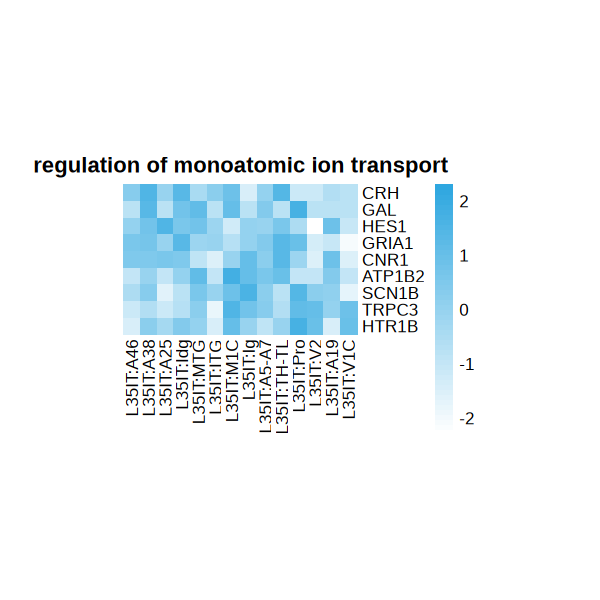

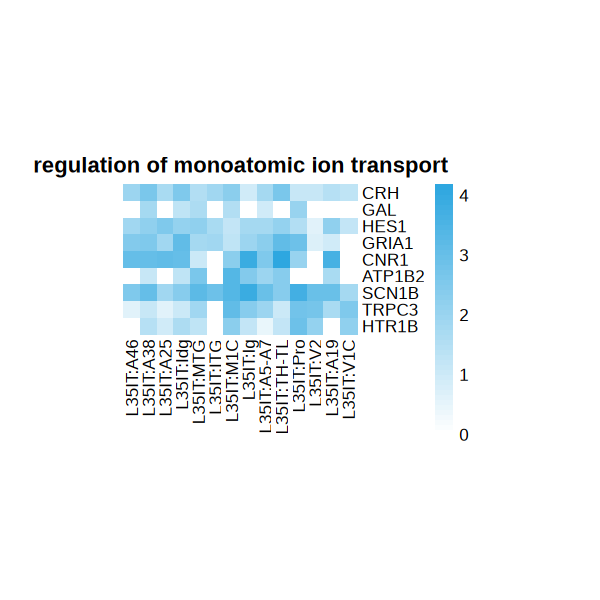

In [1370]:
### Inspect enhancer?
qrange <- abc %>% filter(celltype == f, TargetGene %in% rownames(mtx[rowMeans(mtx) > 0.5, ])) %>% 
mutate(TargetGene = factor(TargetGene, levels = rownames(mtx[rowMeans(mtx) > 0.5, ]))) %>%
arrange(TargetGene)

df <- list()
for (g in unique(qrange$TargetGene)){
    qrange1 <- qrange %>% filter(TargetGene == g) %>% select(range) %>% unlist
    if (length(qrange1) > 1){
        df[[g]] <- log2(cpm1[qrange1, paste0(f, ":", axis_df$region)] + 1) %>% colMeans %>% as.data.frame %>% t
    }else{
         df[[g]] <- log2(cpm1[qrange1, paste0(f, ":", axis_df$region)] + 1) %>% as.data.frame %>% t
    }
}
mtx2 <- do.call(rbind, df)
rownames(mtx2) <- unique(qrange$TargetGene)

t2 <- mtx2 %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "row", 
         cellwidth = 10, cellheight = 10, main = fterm,
         show_rownames = T, # breaks = seq(0, 5, 0.1), 
         treeheight_row = F, angle_col = 90, border_color = NA,
         color = colorRampPalette(c("white", "#2EA7E0"))(50))

t3 <- mtx2 %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "none", 
         cellwidth = 10, cellheight = 10, main = fterm,
         show_rownames = T, # breaks = seq(0, 5, 0.1), 
         treeheight_row = F, angle_col = 90, border_color = NA,
         color = colorRampPalette(c("white", "#2EA7E0"))(50))

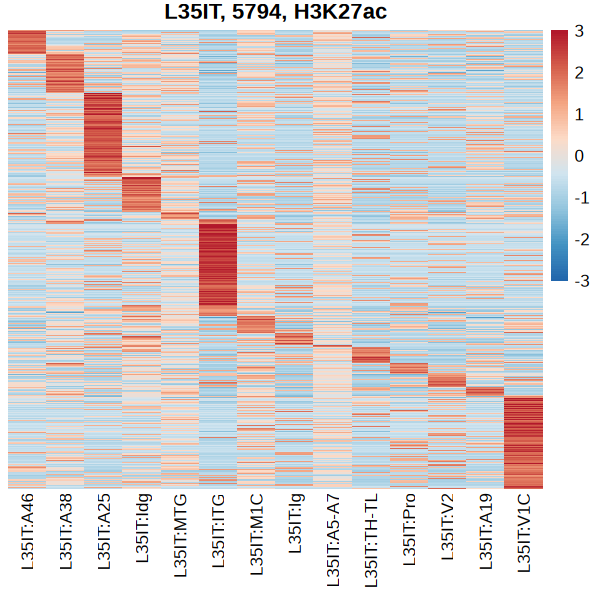

In [1379]:
tmp <- read.table("../Figure/FIG4_cortex_cells_H3K27ac_regional_DHR.txt", 
                  row.names = 1, header = T, sep = "\t") 
f <- "L35IT"
qgene <- tmp %>%
filter(celltype == f, FDR < 0.05, abs(logFC) >= 1) %>%
select(feature) %>% unlist %>% as.character 

rmat <- log2(cpm1[qgene, paste0(f, ":", axis_df$region)] + 1)
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ] 

options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- smat %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "row", main = paste0(f, ", ", nrow(smat), ", H3K27ac"),
         show_rownames = F, treeheight_row = F, angle_col = 90, border_color = NA, breaks = seq(-3, 3, 0.06), 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

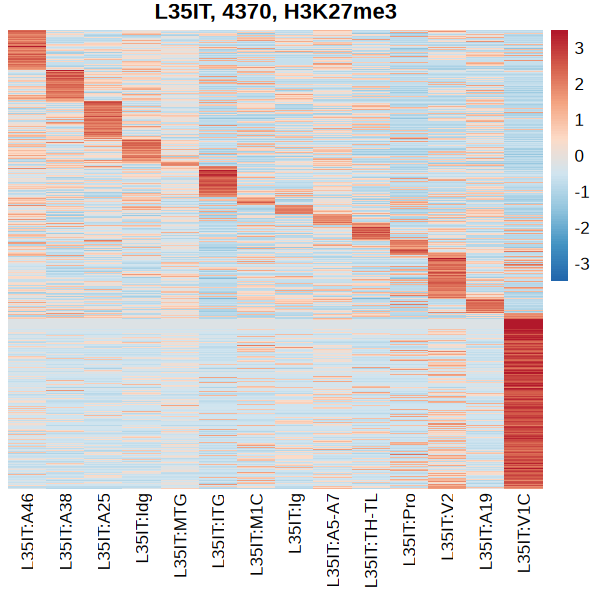

In [1447]:
tmp <- read.table("../Figure/FIG4_cortex_cells_H3K27me3_regional_DHR.txt", 
                  row.names = 1, header = T, sep = "\t") 

f <- "L35IT"
qgene <- tmp %>%
filter(celltype == f, FDR < 0.05, abs(logFC) >= 1) %>%
select(feature) %>% unlist %>% as.character 

rmat <- log2(cpm2[qgene, paste0(f, ":", axis_df$region)] + 1)
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ] 

options(repr.plot.width = 5, repr.plot.height = 5)
t1 <- smat %>%
pheatmap(cluster_col = F, cluster_row = F, scale = "row", main = paste0(f, ", ", nrow(smat), ", H3K27me3"),
         show_rownames = F, treeheight_row = F, angle_col = 90, border_color = NA, #breaks = seq(-3, 3, 0.06), 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

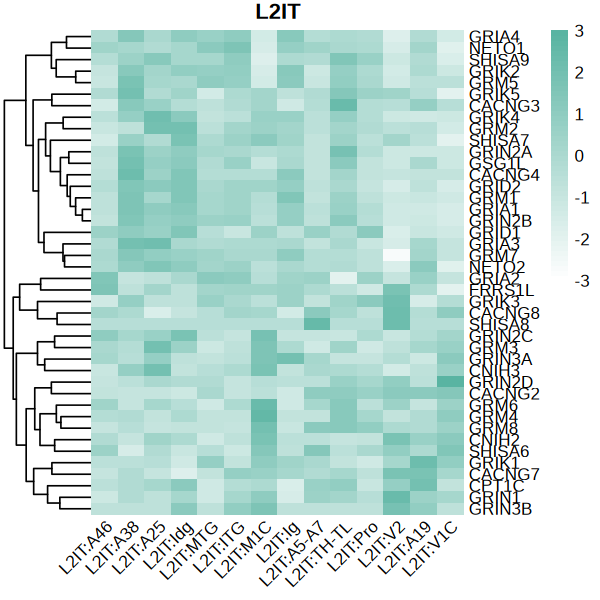

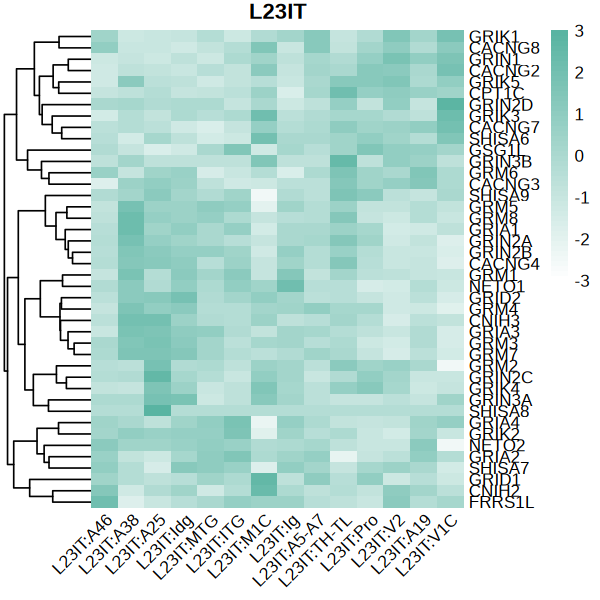

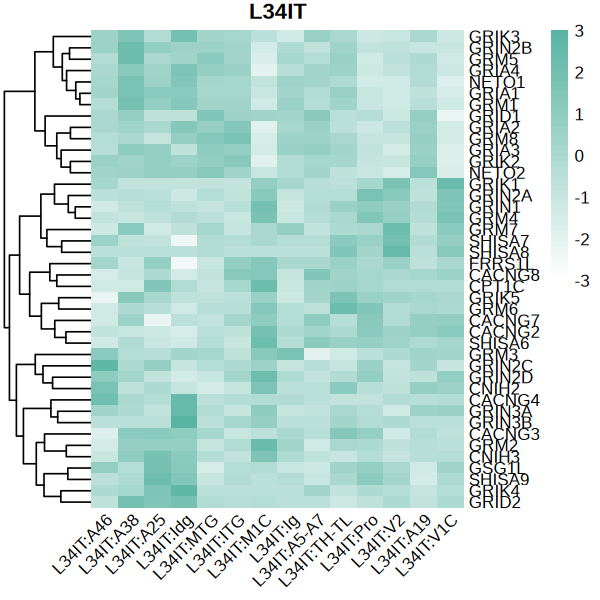

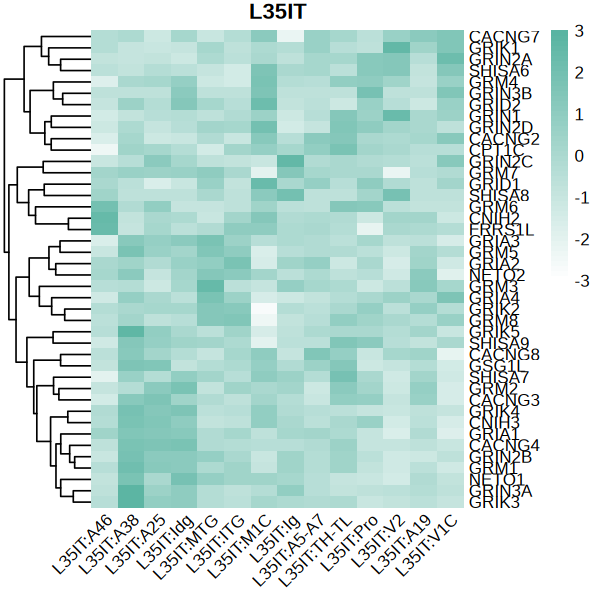

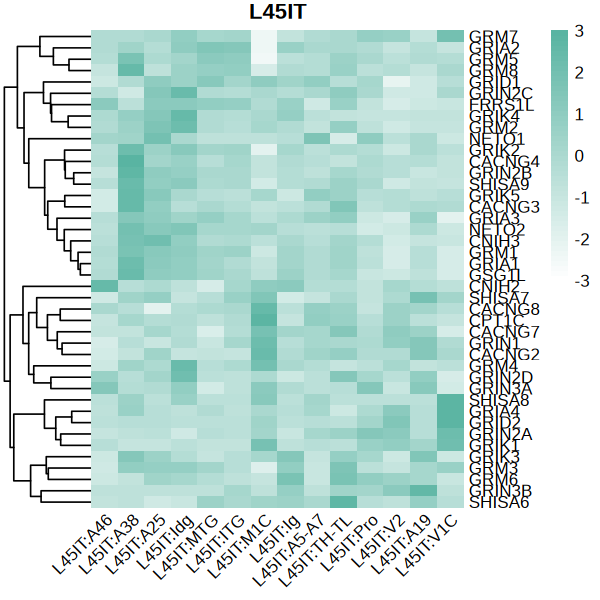

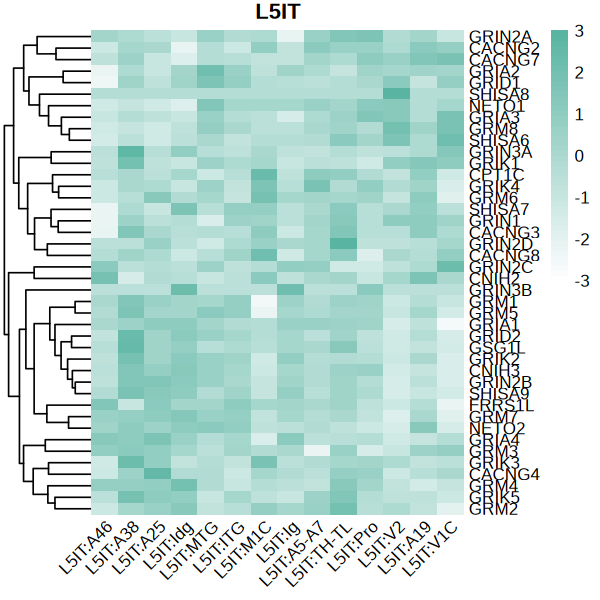

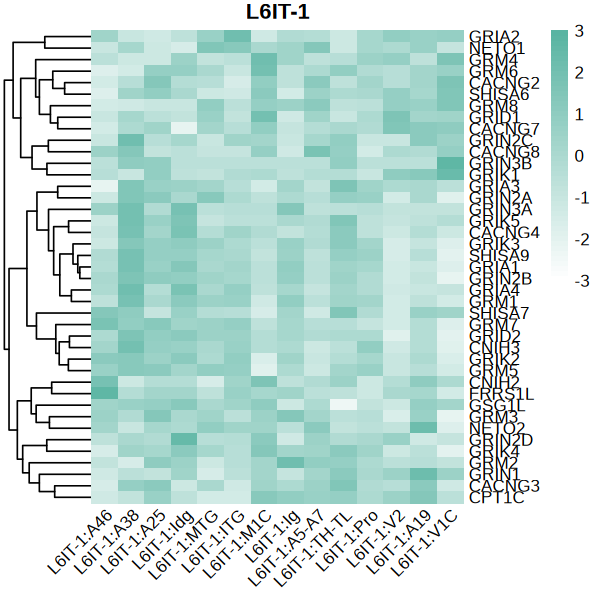

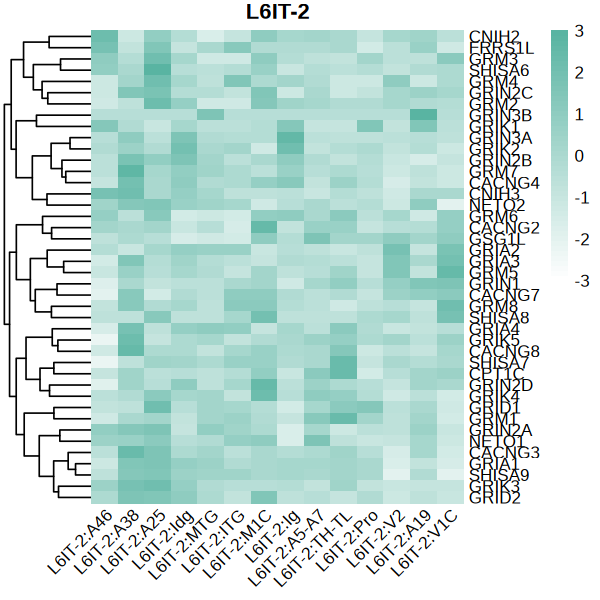

In [1230]:
clist <- list()

options(repr.plot.width = 5, repr.plot.height = 5)
for (ct in c("L2IT", "L23IT", "L34IT", "L35IT", "L45IT", "L5IT", "L6IT-1", "L6IT-2")){
    qorder <- intersect(paste0(ct, ":", qregion), colnames(rpkm1))
    mtx <- rpkm1[qgene$V1, qorder]
    mtx <- mtx[rowSums(mtx) > 0,]
    clist[[ct]] <- mtx
    mtx %>%
    pheatmap(cluster_rows = T, cluster_cols = F, scale = "row", angle_col = 45, 
             border_color = NA, color = colorRampPalette(c("white", "#59b4a2"))(50), # color = viridis(50), 
             breaks = seq(-3, 3, 0.12), main = ct)
}

In [1224]:
### we may need to run correlation to find out whether AMPA receptor show trend
flist <- list()
for (f in names(clist)){
    x <- clist[[f]]
    fflist <- list()
    for (i in 1:nrow(x)){
        tmp <- cor.test(unlist(x[i, intersect(paste0(f, ":", axis_df$region), colnames(x))]), 1:ncol(x), method = "spearman")
        fflist[[i]] <- data.frame(pval = tmp$p.value, rho = tmp$estimate, celltype = f, gene = rownames(x)[i])
    }
    fflist <- do.call(rbind, fflist)
    fflist$qval <- p.adjust(fflist$pval, method = "BH")
    flist[[f]] <- fflist
}

flist <- do.call(rbind, flist)

Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, ":", axis_df$region), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(unlist(x[i, intersect(paste0(f, "

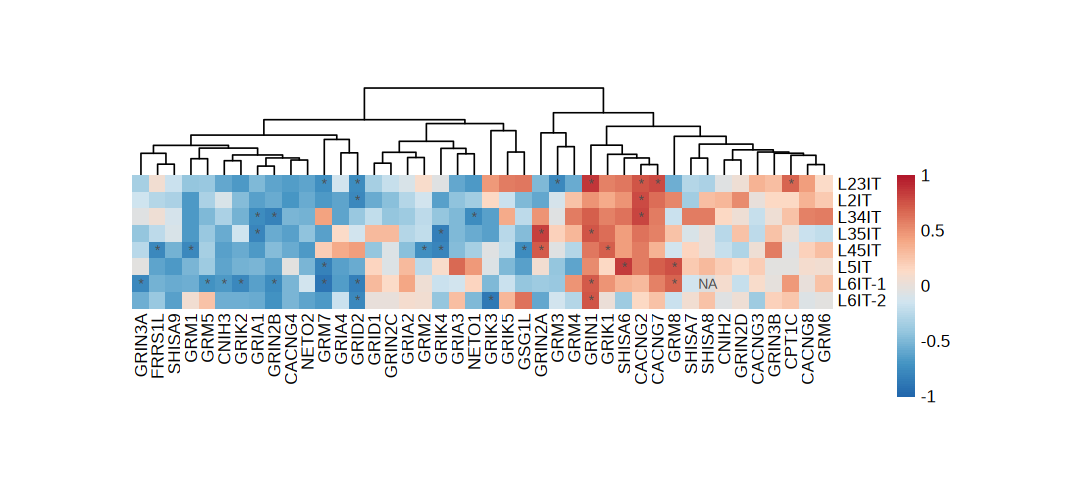

In [1228]:
rmat <- flist %>%
reshape2::dcast(celltype ~ gene, value.var = "rho") %>%
tibble::column_to_rownames('celltype')

lmat <- flist %>%
reshape2::dcast(celltype ~ gene, value.var = "qval") %>%
tibble::column_to_rownames('celltype')
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 9, repr.plot.height = 4)
t0 <- rmat %>%
pheatmap(cluster_rows = F, cluster_cols = T, scale = "none", angle_col = 90, 
         cellwidth = 10, cellheight = 10, display_number = lmat, 
         border_color = NA, breaks = seq(-1, 1, 0.02),
         color = rev(colorRampPalette(brewer.pal(name = "RdBu", n = 8))(100)))

In [1229]:
ggsave(t0, filename = "../Figure/FIG4_cortex_IT_AMPR_receptor_usage_SCC.pdf", dpi = 300, height = 4, width = 9)

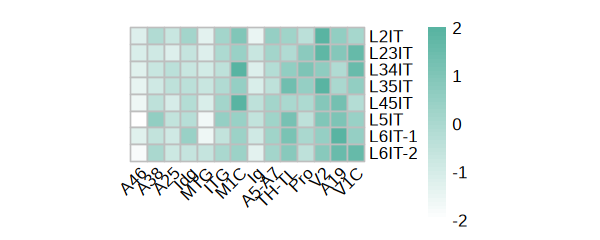

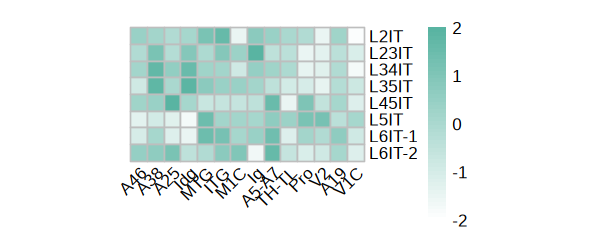

In [1252]:
tmtx <- do.call(rbind, lapply(clist, function(x) x %>% setNames(axis_df$region) %>% mutate(gene = rownames(.))))
tmtx$celltype <- gsub("([^.]+)\\.([^.]+)", "\\1", rownames(tmtx))

t1 <- tmtx %>% filter(gene == "GRIN1") %>%
tibble::rownames_to_column("id") %>%
select(c(axis_df$region, celltype)) %>%
tibble::column_to_rownames("celltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", angle_col = 45, 
         cellwidth = 10, cellheight = 10,
         border_color = "grey", color = colorRampPalette(c("white", "#59b4a2"))(50), # color = viridis(50), 
         breaks = seq(-2, 2, 0.08))

t2 <- tmtx %>% filter(gene == "NETO1") %>%
tibble::rownames_to_column("id") %>%
select(c(axis_df$region, celltype)) %>%
tibble::column_to_rownames("celltype") %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "row", angle_col = 45, 
         cellwidth = 10, cellheight = 10,
         border_color = "grey", color = colorRampPalette(c("white", "#59b4a2"))(50), # color = viridis(50), 
         breaks = seq(-2, 2, 0.08))

In [1253]:
ggsave(t1, filename = "../Figure/FIG4_cortex_IT_GRIN1_regional_RPKM.pdf", dpi = 300, height = 4, width = 4)
ggsave(t2, filename = "../Figure/FIG4_cortex_IT_NETO1_regional_RPKM.pdf", dpi = 300, height = 4, width = 4)

In [1250]:
tmtx %>% filter(gene == "NETO1") %>%
tibble::rownames_to_column("id") %>%
select(c(axis_df$region, celltype)) 

A46       A38       A25      Idg       MTG       ITG       M1C      
1 3.9111241 3.7425486 3.510833 3.7151784 4.4514586 4.7573175 2.5643020
2 2.1333044 2.6962208 2.095292 2.6049564 2.1610287 2.5883232 2.3504493
3 2.2993852 3.6115263 2.658878 3.4715380 2.4157169 2.3062743 1.4437665
4 1.2246588 1.7894908 1.411312 1.8011597 1.5713932 1.4937486 1.4946379
5 0.9643276 0.9815999 1.133484 0.9454733 0.8669663 0.8731677 0.8736028
6 2.4479179 2.5586955 2.459576 2.3102087 3.2869161 2.8968975 2.9114389
7 3.8948856 4.3035780 3.841255 3.7206102 4.7804678 4.7200359 4.2903157
8 2.4759544 2.5202055 2.688794 2.1502194 2.2408259 2.5364511 2.6122980
  Ig        A5-A7    TH-TL     Pro       V2        A19       V1C       celltype
1 4.1630042 3.926823 3.6253069 3.5343888 2.5664437 3.8126982 2.2932560 L2IT    
2 3.0943417 2.018364 2.0249803 1.5657516 1.6192950 2.0384403 1.7199862 L23IT   
3 2.6091589 2.359839 2.1101593 0.9860654 1.1296771 2.0432662 0.7188441 L34IT   
4 1.4459863 1.311822 1.2060357 1.1776209 1.0931663 1.3628209 1.2278931 L35IT   
5 0.8946411 1.094115 0.7886864 1.0430676 0.8852452 0.9456087 0.8156138 L45IT   
6 2.8880253 3.056659 2.9514886 3.2011683 3.2181903 2.7373977 2.8834025 L5IT    
7 4.4285157 4.751591 3.8219511 4.3403784 4.2232693 4.5165288 3.9348576 L6IT-1  
8 1.7286187 2.850609 2.0766729 1.9405974 2.0005318 2.3344249 1.9048090 L6IT-2

## A-P axis analysis of cell type composition

In [1483]:
tcomp1 <- lmeta %>% filter(region %in% qregion, class == "NonN", subclass_corrected %in% qclass) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()

tcomp2 <- lmeta %>% filter(region %in% qregion, class != "NonN", subclass_corrected %in% qclass) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()

tcomp <- rbind(tcomp1, tcomp2)
tcomp$group <- border[match(tcomp$region, border$Miniatlas), ]$group %>% as.integer

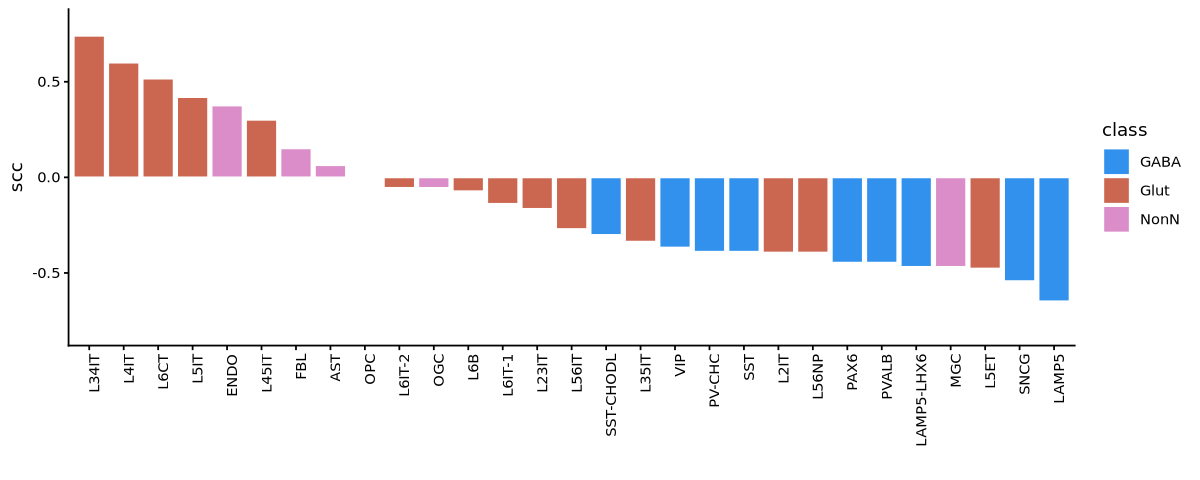

In [11]:
tcomp1 <- lmeta %>% filter(region %in% qregion, class == "NonN", subclass_corrected %in% qclass) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()

tcomp2 <- lmeta %>% filter(region %in% qregion, class != "NonN", subclass_corrected %in% qclass) %>%
dplyr::select(region, subclass_corrected) %>%
table %>% as.data.frame %>%
group_by(region) %>%
mutate(ratio = Freq/sum(Freq)) %>%
ungroup()

tcomp <- rbind(tcomp1, tcomp2)
tcomp$group <- border[match(tcomp$region, border$Miniatlas), ]$group %>% as.integer

dlist <- list()
for (f in qclass){
    tmp <- tcomp %>% filter(subclass_corrected == f, region %in% qregion) %>% dplyr::select(ratio, group)
    test <- cor.test(tmp$ratio, tmp$group, method = "spearman") ### rank!!!
    dlist[[f]] <- data.frame(region = f, scc = as.numeric(test$estimate), pvalue = test$p.value)
}

dlist <- do.call(rbind, dlist)
dlist$qval <- p.adjust(dlist$pvalue, method = "BH")

t1 <- merge(distinct(lmeta[,c("subclass_corrected", "class")]), dlist, by.x = "subclass_corrected", by.y = "region") %>% 
arrange(desc(scc)) %>%
mutate(subclass_corrected = factor(subclass_corrected, levels = subclass_corrected)) %>% 
ggplot(aes(x = subclass_corrected, y = scc, fill = class)) + 
geom_col(color = "white") + 
# geom_point(size = 3) + 
# geom_hline(yintercept = 0, linetype = 2, color = "grey") + 
theme_classic() + xlab("") + ylim(-0.8, 0.8) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
scale_fill_manual(values = ccol1) 

options(repr.plot.width = 10, repr.plot.height = 4)
t1

### Not significant...?

### Prepare regional features RPKM

In [24]:
# col_names <- read.csv("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.region.rpkm.txt", header = F, sep = "\t")[1,] %>% unlist %>% as.character
# expr <- read.csv("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.region.rpkm.txt", header = T, sep = "\t")
# colnames(expr) <- col_names[1:(length(col_names) - 1)]
# cond <- stringr::str_split_fixed(colnames(expr), pattern = ":", n = 2) %>% as.data.frame %>% setNames(c("subclass", "region"))

In [219]:
### subsample 500 cells per region per cell type to calculate gex correlation
set.seed(921)
qcell <- list()
for (ct in qclass){
    for (f in qregion){
        tmp <- mmg@meta.data %>% filter(subclass_corrected == ct, region == f) %>% rownames
        if (length(tmp) >= 500){
            tmp <- sample(tmp, size = 500, replace = F)
        }
        qcell[[paste0(ct, ":", f)]] <- tmp
    }
}

In [ ]:
tmp <- subset(mmg, cells = unlist(qcell))
tmp$group <- paste0(tmp$subclass_corrected, ":", tmp$region)
rexpr <- ArcXPM(tmp[["RNA"]]$counts, meta = tmp@meta.data, group.by = 'group', method = "RPKM", 
                         gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")

write.table(rexpr, "MiniAtlas_RNA_merged_dual_filt_clean_corrected.subset_region_subclass.rpkm", sep = "\t", quote = F,
           row.names = T, col.names = T)
# rexpr <- read.table("MiniAtlas_RNA_merged_dual_filt_clean_corrected.subset_region_subclass.rpkm", sep = "\t", 
#            row.names = 1, header = T, check.names = FALSE)

In [80]:
set.seed(921)
# mtx <- tmp[["RNA"]]$counts
# colnames(mtx) <- sample(colnames(mtx), size = ncol(mtx), replace = F)
# rownames(mtx) <- sample(rownames(mtx), size = nrow(mtx), replace = F)
# tmp2 <- CreateAssayObject(mtx)
# tmp2 <- CreateSeuratObject(tmp2, meta.data = tmp@meta.data)
tmp2 <- tmp
tmp2$subclass_corrected <- sample(tmp2$subclass_corrected, size = length(tmp2$subclass_corrected), replace = F) %>% as.character
tmp2$region <- sample(tmp2$region, size = length(tmp2$region), replace = F) %>%as.character
tmp2$group <- paste0(tmp2$subclass_corrected, ":", tmp2$region)

rexpr2 <- ArcXPM(tmp2[["RNA"]]$counts, meta = tmp2@meta.data, group.by = 'group', method = "RPKM", 
                 gene_length = "/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
write.table(rexpr2, "MiniAtlas_RNA_merged_dual_filt_clean_corrected.subset_region_subclass.shuffle.rpkm", sep = "\t", quote = F,
           row.names = T, col.names = T)

sparsity: 0.626555369065262
coarse dgTMatrix into Matrix.
check readSums:  406 
check obj_mtx_collapse:  406 


In [ ]:
qs::qsave(tmp, "MiniAtlas_RNA_merged_dual_filt_clean_corrected.subset.qs")

## Determine the axial dependence in the regional DE features

In [757]:
### calculate for only DEG
dlist <- read.table("../Figure/FIG4_cortex_cells_regional_DEG.txt", header = T) %>%
tibble::rownames_to_column("id") %>%
mutate(celltype = gsub("([^\\.]+).*", "\\1", id))
qfeature <- dlist %>% filter(FDR < 0.01, abs(logFC) >= 1, celltype %in% qclass) %>%
select(gene, celltype) %>% distinct
dim(qfeature)

[1] 50759     2

In [758]:
axis_cor_test <- function(expr_mat,
                          axis_df,
                          method = c("spearman", "pearson"),
                          log_transform = TRUE,
                          min_non_na = 3) {
  method <- match.arg(method)
  
  # Reorder columns to match axis_df
  expr_mat <- expr_mat[, axis_df$region, drop = FALSE]
  axis     <- axis_df$axis_pos
  
  # Optional log1p transform
  if (log_transform) {
    expr <- log1p(expr_mat)
  } else {
    expr <- expr_mat
  }
  
  genes <- rownames(expr)
  G     <- nrow(expr)
  
  res_list <- vector("list", G)
  
  for (i in seq_len(G)) {
    g <- genes[i]
    y <- as.numeric(expr[i, ])
    
    # Drop NA / non-finite pairs
    ok <- is.finite(y) & is.finite(axis)
    y2 <- y[ok]
    a2 <- axis[ok]
    
    # Not enough data points
    if (length(y2) < min_non_na) {
      res_list[[i]] <- data.frame(
        gene = g,
        rho  = NA_real_,
        pval = NA_real_
      )
      next
    }
    
    # Zero variance in gene or axis → correlation undefined
    if (sd(y2) == 0 || sd(a2) == 0) {
      res_list[[i]] <- data.frame(
        gene = g,
        rho  = NA_real_,
        pval = NA_real_
      )
      next
    }
    
    ct <- suppressWarnings(cor.test(y2, a2, method = method))
    
    res_list[[i]] <- data.frame(
      gene = g,
      rho  = unname(ct$estimate),
      pval = ct$p.value
    )
  }
  
  res <- do.call(rbind, res_list)
  rownames(res) <- res$gene
  
  # FDR
  res$padj <- p.adjust(res$pval, method = "BH")
  
  # Direction: assume larger axis_pos = more posterior
  res$direction <- ifelse(
    is.na(res$rho), NA_character_,
    ifelse(res$rho > 0, "posterior_high",
           ifelse(res$rho < 0, "anterior_high", "flat"))
  )
  
  res
}

In [911]:
axis_df <- border %>% filter(Miniatlas %in% qregion) %>% select(Miniatlas, group) %>% distinct %>% setNames(c("region","axis_pos")) %>%
group_by(region) %>% summarise(axis_pos = mean(axis_pos)) %>% ungroup %>% arrange(axis_pos) %>% as.data.frame

set.seed(921) 
mlist <- list()
for (f in qclass){
    tmp <- list()
    for (file in list.files(paste0("region_DEG/", f))){
        fname <- gsub(".*.__edgeR_([^_]+)_vs_all.tsv", "\\1", file)
        if ((fname %in% qregion) & (fname %in% as.character(rvalid[rvalid$subclass_corrected == f,]$region))){
            tmp[[i]] <- read.table(paste0("region_DEG/", f, "/", file), header = T, row.names = 1) %>% 
            mutate(region = fname) %>% tibble::rownames_to_column("gene")
            i = i + 1
        }
    }
    tmp <- do.call(rbind, tmp)
    qqgene <- tmp %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% select(gene) %>% unlist %>% unique

    expr_mat <- rexpr[qqgene, grep(paste0(f, ":"), colnames(rexpr))]
    colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

    nz_regions <- rowSums(expr_mat > 0)
    keep <- (nz_regions >= 7)  # adjust (15 regions, need to have half of them > 0)
    expr_mat <- expr_mat[keep, ,drop=F]
    
    ### make sure regions match (e.g. L4IT)
    valid <- intersect(colnames(expr_mat), axis_df$region)
    qdf <- axis_df %>% filter(region %in% valid) %>% arrange(axis_pos)
    if(nrow(expr_mat) > 0){
        cor_results <- axis_cor_test(expr_mat, qdf, method = "spearman", log_transform = TRUE, min_non_na = 3)
        mlist[[f]] <- cor_results %>% mutate(celltype = f)
    }
}

`stat_binline()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_binline()`).”
Picking joint bandwidth of 0.0913

Warning message:
“Removed 14 rows containing non-finite outside the scale range (`stat_density_ridges()`).”


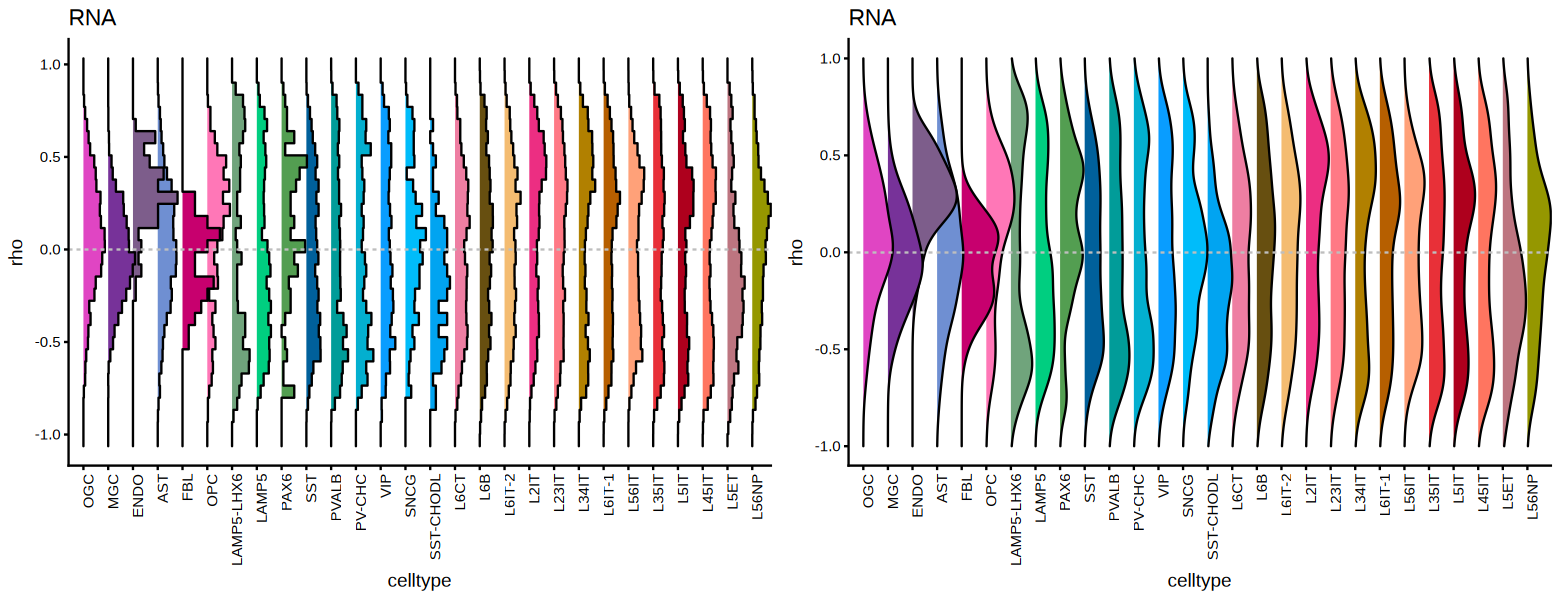

In [913]:
library(ggridges)
t1 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype)) + 
geom_density_ridges(stat = "binline") + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("RNA") + coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

t2 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype)) + 
geom_density_ridges(from = -1, to = 1) + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("RNA") + coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

options(repr.plot.width = 13, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)

fig1

In [414]:
flist <- flist2 <- list()
for (f in names(mlist)){ 
    qqgene <- mlist[[f]] %>% filter(!is.na(pval)) %>%
    filter(padj < 0.05) %>% select(gene) %>% unlist %>% unique %>% as.character
    if (length(qqgene) >= 5){
        qtable <- clusterProfiler::enrichGO(gene = qqgene,
                    OrgDb = org.Hs.eg.db::org.Hs.eg.db,
                    keyType = 'SYMBOL',
                    ont = "BP", # biological process
                    pAdjustMethod = "BH", 
                    pvalueCutoff = 0.05, 
                    qvalueCutoff = 0.05, 
                    readable = TRUE)
        flist[[f]] <- qtable@result %>% mutate(celltype = f) 
        qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
        flist2[[f]] <- qtable2@result %>% mutate(celltype = f) # %>% filter(p.adjust < 0.05)
    }
}

do.call(rbind, flist2) %>%
dplyr::select(celltype) %>% table

write.table(do.call(rbind, flist), "AP_axis/cortex_cells_axis_lgm_genes_enrichGO.xls", 
            sep = "\t", quote = F, row.names = F, col.names = T)
write.table(do.call(rbind, flist2),
            "AP_axis/cortex_cells_axis_lgm_genes_enrichGO_simplify.xls", 
            sep = "\t", quote = F, row.names = F, col.names = T)

celltype
      L2IT      L34IT      L35IT      L45IT      L56NP       L5ET       L5IT 
         2          1         20          2          5         23          8 
       L6B     L6IT-2 LAMP5-LHX6     PV-CHC      PVALB 
         1          7         47          2          2 

In [425]:
do.call(rbind, flist) %>% filter(p.adjust < 0.05) %>%
select(celltype) %>% table

celltype
      L2IT      L34IT      L35IT      L45IT      L56NP       L5ET       L5IT 
         4          1         41          3          7         32         10 
       L6B     L6IT-2 LAMP5-LHX6     PV-CHC      PVALB 
         2         11         95          3          4 

In [508]:
flist2[["L5IT"]] %>% filter(ID %in% intersect(flist2[["L5IT"]]$ID, flist2[["LAMP5-LHX6"]]$ID))

ID         Description                          GeneRatio BgRatio  
GO:1901888 GO:1901888 regulation of cell junction assembly 14/306    268/18986
           RichFactor FoldEnrichment zScore   pvalue       p.adjust  
GO:1901888 0.05223881 3.241196       4.729281 0.0001218715 0.03985197
           qvalue    
GO:1901888 0.03668973
           geneID                                                                                     
GO:1901888 SLIT1/MEF2C/PTK2/IGSF11/LRRN1/BDNF/CNTNAP2/MARK1/CBLN1/GPM6B/SEMA4D/PRICKLE1/MAP4K4/EPB41L5
           Count celltype
GO:1901888 14    L5IT

In [509]:
g1 <- flist2[['L5IT']] %>% filter(p.adjust	< 0.05) %>% filter(ID == "GO:1901888") %>% select(geneID) %>% unlist
g1 <- stringr::str_split(g1, pattern = "/") %>% unlist

g2 <- flist2[['LAMP5-LHX6']] %>% filter(p.adjust	< 0.05) %>% filter(ID == "GO:1901888") %>% select(geneID) %>% unlist
g2 <- stringr::str_split(g2, pattern = "/")%>% unlist

length(g1)
length(g2)
intersect(g1, g2) %>% length

[1] 14

[1] 12

[1] 2

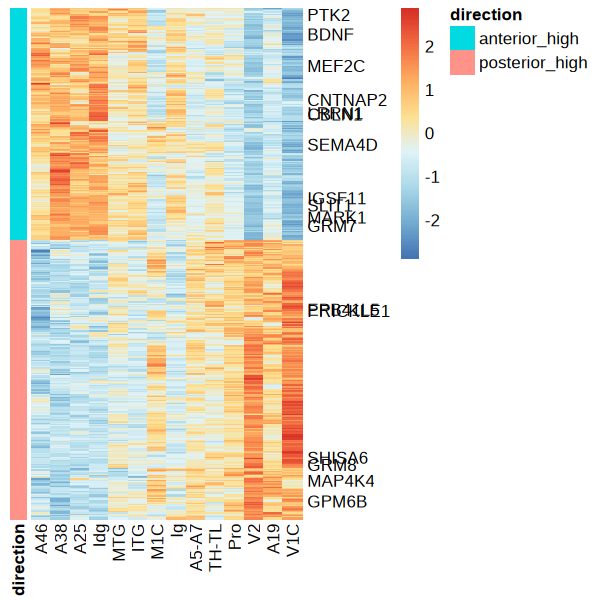

In [520]:
### example
f <- "L5IT"
qqgene <- mlist[[f]] %>% filter(!is.na(pval)) %>%
filter(padj < 0.05) %>% select(gene) %>% unlist %>% unique %>% as.character

expr_mat <- rexpr[qqgene, grep(f, colnames(rexpr))]
colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

canno <- mlist[[f]] %>% filter(gene %in% qqgene) %>% 
tibble::rownames_to_column('id') %>%
tibble::column_to_rownames("gene") %>% select(direction)

labelr <- qqgene
g1 <- flist2[[f]] %>% filter(p.adjust < 0.05) %>% filter(ID == "GO:1901888") %>% select(geneID) %>% unlist
g1 <- stringr::str_split(g1, pattern = "/") %>% unlist

labelr[!(labelr %in% c(g1, qgene$V1))] <- ""
t1 <- expr_mat[qqgene, intersect(axis_df$region, colnames(expr_mat))] %>%
pheatmap(cluster_col = F, scale = "row", annotation_row = canno,
         show_rownames = T, treeheight_row = F, angle_col = 90, 
         labels_row = labelr, 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(100)))

ggsave(t1, filename = paste0("../Figure/", f, "_cortex_cells_axis_cor_genes.pdf"), dpi = 300, height = 5, width = 6)

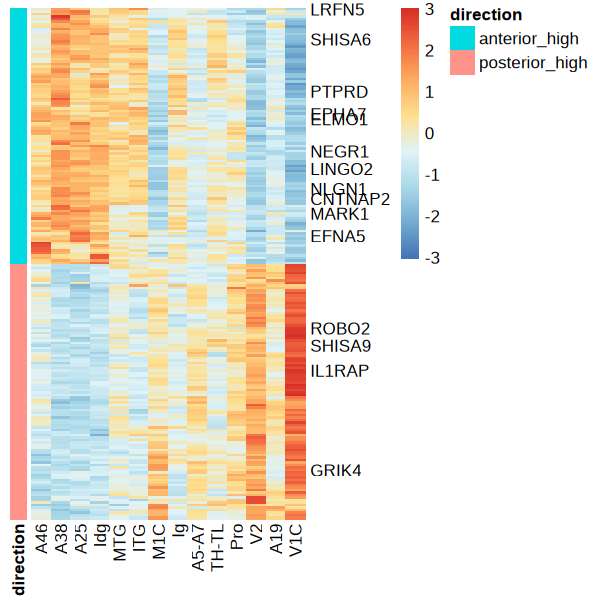

In [519]:
### example
f <- "LAMP5-LHX6"
qqgene <- mlist[[f]] %>% filter(!is.na(pval)) %>%
filter(padj < 0.05) %>% select(gene) %>% unlist %>% unique %>% as.character

expr_mat <- rexpr[qqgene, grep(f, colnames(rexpr))]
colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

canno <- mlist[[f]] %>% filter(gene %in% qqgene) %>% 
tibble::rownames_to_column('id') %>%
tibble::column_to_rownames("gene") %>% select(direction)

labelr <- qqgene
g1 <- flist2[[f]] %>% filter(p.adjust	< 0.05) %>% filter(ID == "GO:1901888") %>% select(geneID) %>% unlist
g1 <- stringr::str_split(g1, pattern = "/") %>% unlist

labelr[!(labelr %in% c(g1, qgene$V1))] <- ""
t1 <- expr_mat[qqgene, intersect(axis_df$region, colnames(expr_mat))] %>%
pheatmap(cluster_col = F, scale = "row", annotation_row = canno,
         show_rownames = T, treeheight_row = F, angle_col = 90, 
         labels_row = labelr, 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(100)))

# ggsave(t1, filename = paste0("../Figure/", f, "_cortex_cells_axis_cor_genes.pdf"), dpi = 300, height = 5, width = 6)

In [419]:
library(splines)

axis_perm_spline_fast <- function(expr_mat, axis_df,
                                  n_perm = 1000,
                                  df_spline = 1) {
  # Reorder columns to match axis_df
  expr_mat <- expr_mat[, axis_df$region]
    expr_mat <- expr_mat[rowSums(expr_mat) > 0,]
    axis     <- axis_df$axis_pos
  
  # Log transform
  expr_log <- log1p(expr_mat)         # genes x regions
  genes    <- rownames(expr_log)
  
  # Y: regions x genes (for matrix algebra)
  Y <- t(as.matrix(expr_log))         # R x G
  R <- nrow(Y)
  G <- ncol(Y)
  
  # --- Null model: constant (no axis) ---
  mu   <- colMeans(Y)                 # mean per gene
  Yc   <- sweep(Y, 2, mu, "-")        # center by mean
  SSE0 <- colSums(Yc^2)               # SSE under null
  valid <- SSE0 > 0
  
  # --- Design matrix for spline model (fixed, no permuting) ---
  X      <- ns(axis, df = df_spline)  # R x (df_spline)
  X_full <- cbind(1, X)               # add intercept; R x K
  K      <- ncol(X_full)
  
  XtX_inv <- solve(t(X_full) %*% X_full)        # K x K
  
  # --- Observed R^2 for all genes ---
  # Beta = (X'X)^(-1) X'Y   (K x G)
  Beta_obs <- XtX_inv %*% (t(X_full) %*% Y)
  Yhat_obs <- X_full %*% Beta_obs              # R x G
  resid_obs <- Y - Yhat_obs
  SSE1_obs  <- colSums(resid_obs^2)
  obs_r2    <- 1 - SSE1_obs / SSE0
  obs_r2[!valid] <- NA_real_
  
  # --- Permutation loop (permute regions, reuse spline design) ---
  ge_count <- integer(G)
    for (b in seq_len(n_perm)) {
    perm_idx <- sample.int(R)        # permute region order
    Yp       <- Y[perm_idx, , drop = FALSE]  # R x G
    
    # Fit spline model to permuted Y (same X_full)
    Beta_p  <- XtX_inv %*% (t(X_full) %*% Yp)
    Yhat_p  <- X_full %*% Beta_p
    resid_p <- Yp - Yhat_p
    SSE1_p  <- colSums(resid_p^2)
    r2_p    <- 1 - SSE1_p / SSE0
    
    ge_count <- ge_count + as.integer(r2_p >= obs_r2)
  }
  
  pval <- (1 + ge_count) / (1 + n_perm)
  pval[!valid] <- NA_real_
  
  out <- data.frame(
    gene   = genes,
    obs_r2 = obs_r2,
    pval   = pval,
    padj   = p.adjust(pval, method = "BH"),
    stringsAsFactors = FALSE
  )
  rownames(out) <- genes

    spearman_rho <- apply(expr_log, 1, function(y) {
      suppressWarnings(cor(y, axis, method = "spearman"))
    })
    out$rho <- spearman_rho
  out
}

In [420]:
# expr_mat: genes x regions
# axis_df: has a "region" column matching colnames(expr_mat)
set.seed(921) 
n_perm <- 1000

mlist <- list()
for (f in qclass){
    ### only counts DE genes
    tmp <- list()
    for (file in list.files(paste0("region_DEG/", f))){
        fname <- gsub(".*.__edgeR_([^_]+)_vs_all.tsv", "\\1", file)
        if ((fname %in% qregion) & (fname %in% as.character(rvalid[rvalid$subclass_corrected == f,]$region))){
            tmp[[i]] <- read.table(paste0("region_DEG/", f, "/", file), header = T, row.names = 1) %>% 
            mutate(region = fname) %>% tibble::rownames_to_column("gene")
            i = i + 1
        }
    }
    tmp <- do.call(rbind, tmp)
    qqgene <- tmp %>% filter(FDR < 0.01) %>% select(gene) %>% unlist %>% unique

    ### prepare matrix for test
    expr_mat <- rexpr[qqgene, grep(f, colnames(rexpr))]
    colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

    ### make sure regions match (e.g. L4IT)
    valid <- intersect(colnames(expr_mat), axis_df$region)
    qdf <- axis_df %>% filter(region %in% valid) %>% arrange(axis_pos)
    
    axis_perm_results <- axis_perm_spline_fast(expr_mat, qdf, n_perm = n_perm, df_spline = 1) ### just linear 

    mlist[[f]] <- axis_perm_results %>% mutate(celltype = f)
}

In [421]:
saveRDS(mlist, "axis_gex_spline_fit.rds")

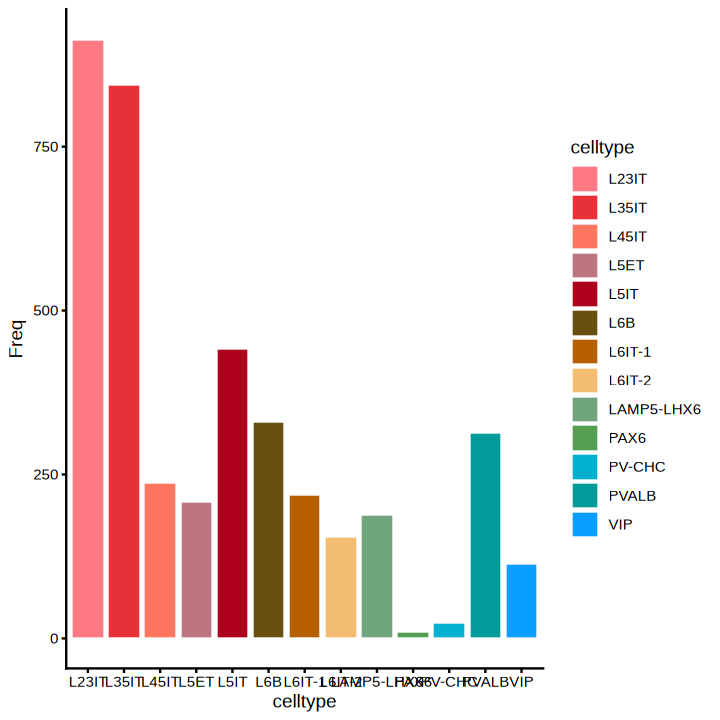

In [422]:
do.call(rbind, mlist) %>%
filter(!is.na(pval)) %>%
filter(padj < 0.05) %>% 
select(celltype) %>% table %>% as.data.frame %>%
ggplot(aes(x = celltype, y = Freq, fill = celltype)) + 
geom_col(color = "white") + 
theme_classic() + 
scale_fill_manual(values = ccol2)

## Calculate cor for cCREs using H3K27ac / H3K27me3

In [626]:
ac <- read_h5ad("../07.cCREs/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.h5ad")
me3 <- read_h5ad("../07.cCREs/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.h5ad")

In [627]:
ac <- CreateSeuratObject(t(ac$X), meta.data = ac$obs)
me3 <- CreateSeuratObject(t(me3$X), meta.data = me3$obs)

ac$nCount_histone <- ac$n_fragment %>% as.character %>% as.integer
me3$nCount_histone <- me3$n_fragment %>% as.character %>% as.integer

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”


In [788]:
set.seed(921)
qcell <- list()
for (ct in unique(ac$subclass_corrected)){
    for (f in unique(ac$region)){
        tmp <- ac@meta.data %>% filter(subclass_corrected == ct, region == f) %>% rownames
        if (length(tmp) >= 500){
            tmp <- sample(tmp, size = 500, replace = F)
        }
        qcell[[paste0(ct, ":", f)]] <- tmp
    }
}

tmp <- subset(ac, cells = unlist(qcell))
tmp$group <- paste0(tmp$subclass_corrected, ":", tmp$region)
cpm1 <- ArcXPM(tmp[["RNA"]]$counts, meta = tmp@meta.data, group.by = 'group', method = "CPM")
# write.table(cpm1, "../12.heterogenity/MiniAtlas_H3K27ac_snATAC_whole.union.peaks_250601.subset_region_subclass.cpm", 
#             sep = "\t", quote = F, row.names = T, col.names = T)

sparsity: 0.163137897132878
check readSums:  451 
check obj_mtx_collapse:  451 


In [789]:
set.seed(921)
qcell <- list()
for (ct in unique(me3$subclass_corrected)){
    for (f in unique(me3$region)){
        tmp <- me3@meta.data %>% filter(subclass_corrected == ct, region == f) %>% rownames
        if (length(tmp) >= 500){
            tmp <- sample(tmp, size = 500, replace = F)
        }
        qcell[[paste0(ct, ":", f)]] <- tmp
    }
}

tmp <- subset(me3, cells = unlist(qcell))
tmp$group <- paste0(tmp$subclass_corrected, ":", tmp$region)
cpm2 <- ArcXPM(tmp[["RNA"]]$counts, meta = tmp@meta.data, group.by = 'group', method = "CPM")
# write.table(cpm2, "../12.heterogenity/MiniAtlas_H3K27me3_snATAC_whole.union.peaks_250601.subset_region_subclass.cpm", 
#             sep = "\t", quote = F, row.names = T, col.names = T)

sparsity: 0.101122678424848
check readSums:  466 
check obj_mtx_collapse:  466 


In [940]:
hg38 <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-GRCh38.p13_v43/GRCh38/genes/tss_1500bp.bed")
prange <- GenomicRanges::GRanges(hg38[, 1], IRanges::IRanges(as.integer(hg38[, 2]), as.integer(hg38[, 3])))

axis_df <- border %>% filter(Miniatlas %in% qregion) %>% select(Miniatlas, group) %>% distinct %>% setNames(c("region","axis_pos")) %>%
group_by(region) %>% summarise(axis_pos = mean(axis_pos)) %>% ungroup %>% arrange(axis_pos) %>% as.data.frame

set.seed(921) 

mlist <- list()
for (f in qclass){
    tmp <- read.csv(paste0("region_DHR/H3K27ac/", f, '.csv'), header = T) %>% 
    setNames(c("feature", "logFC", "pval", "FDR", "region")) %>%
    filter(region %in% qregion)

    qqgene <- tmp %>% filter(FDR < 0.05, abs(logFC) >= 1) %>% 
    filter(region %in% as.character(acvalid[acvalid$subclass_corrected == f,]$region)) %>%
    select(feature) %>% unlist %>% unique

    expr_mat <- cpm1[qqgene, grep(paste0(f, ":"), colnames(cpm1), value = T)] %>% as.matrix 
    colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

    nz_regions <- rowSums(expr_mat > 0)
    keep <- (nz_regions >= 7)  # adjust
    expr_mat <- expr_mat[keep, ,drop=F]
    
    valid <- intersect(colnames(expr_mat), axis_df$region)
    qdf <- axis_df %>% filter(region %in% valid) %>% arrange(axis_pos)
    if(nrow(expr_mat) > 0){
        # lm_results <- axis_lm(expr_mat, qdf, log_transform = TRUE)
        # mlist[[f]] <- lm_results %>% mutate(celltype = f)
        cor_results <- axis_cor_test(expr_mat, qdf, method = "spearman", log_transform = TRUE, min_non_na = 3)
        mlist[[f]] <- cor_results %>% mutate(celltype = f)
    }
}

`stat_binline()` using `bins = 30`. Pick better value with `binwidth`.

Picking joint bandwidth of 0.0591



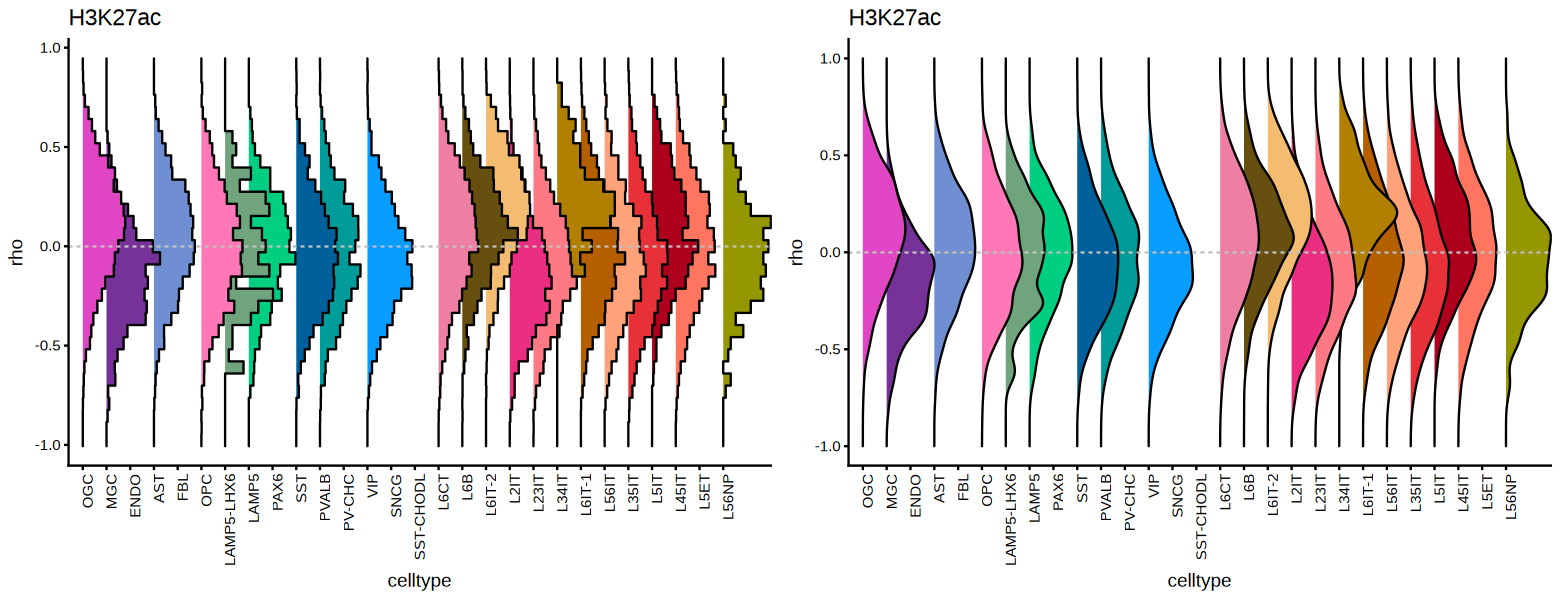

In [941]:
### Drop celltypes with features fewer than 10
t1 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
add_count(celltype) %>% filter(n >= 10) %>%
mutate(celltype = factor(celltype, levels = intersect(corder, torder))) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype, height = ..density..)) + 
geom_density_ridges(stat = "binline") + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27ac") + scale_y_discrete(drop = FALSE) + 
coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

t2 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
add_count(celltype) %>% filter(n >= 10) %>%
mutate(celltype = factor(celltype, levels = intersect(corder, torder))) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype, height = ..density..)) + 
geom_density_ridges(from = -1, to = 1) + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27ac") + scale_y_discrete(drop = FALSE) + 
coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

options(repr.plot.width = 13, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)

fig1

In [926]:
### H3K27me3?
set.seed(921) 

mlist <- list()
for (f in qclass){
    tmp <- read.csv(paste0("region_DHR/H3K27me3/", f, '.csv'), header = T) %>% 
    setNames(c("feature", "logFC", "pval", "FDR", "region")) %>%
    filter(region %in% qregion)

    qqgene <- tmp %>% filter(FDR < 0.05, abs(logFC) >= 1) %>% 
    filter(region %in% as.character(mevalid[mevalid$subclass_corrected == f,]$region)) %>%
    select(feature) %>% unlist %>% unique

    expr_mat <- cpm2[qqgene, grep(paste0(f, ":"), colnames(cpm2), value = T)] %>% as.matrix 
    colnames(expr_mat) <- gsub(paste0(f, ":"), "", colnames(expr_mat))

    nz_regions <- rowSums(expr_mat > 0)
    keep <- (nz_regions >= 7)  # adjust
    expr_mat <- expr_mat[keep, ,drop=F]
    
    valid <- intersect(colnames(expr_mat), axis_df$region)
    qdf <- axis_df %>% filter(region %in% valid) %>% arrange(axis_pos)
    if(nrow(expr_mat) > 0){
        # lm_results <- axis_lm(expr_mat, qdf, log_transform = TRUE)
        # mlist[[f]] <- lm_results %>% mutate(celltype = f)
        cor_results <- axis_cor_test(expr_mat, qdf, method = "spearman", log_transform = TRUE, min_non_na = 3)
        mlist[[f]] <- cor_results %>% mutate(celltype = f)
    }
}

`stat_binline()` using `bins = 30`. Pick better value with `binwidth`.

Picking joint bandwidth of 0.0781



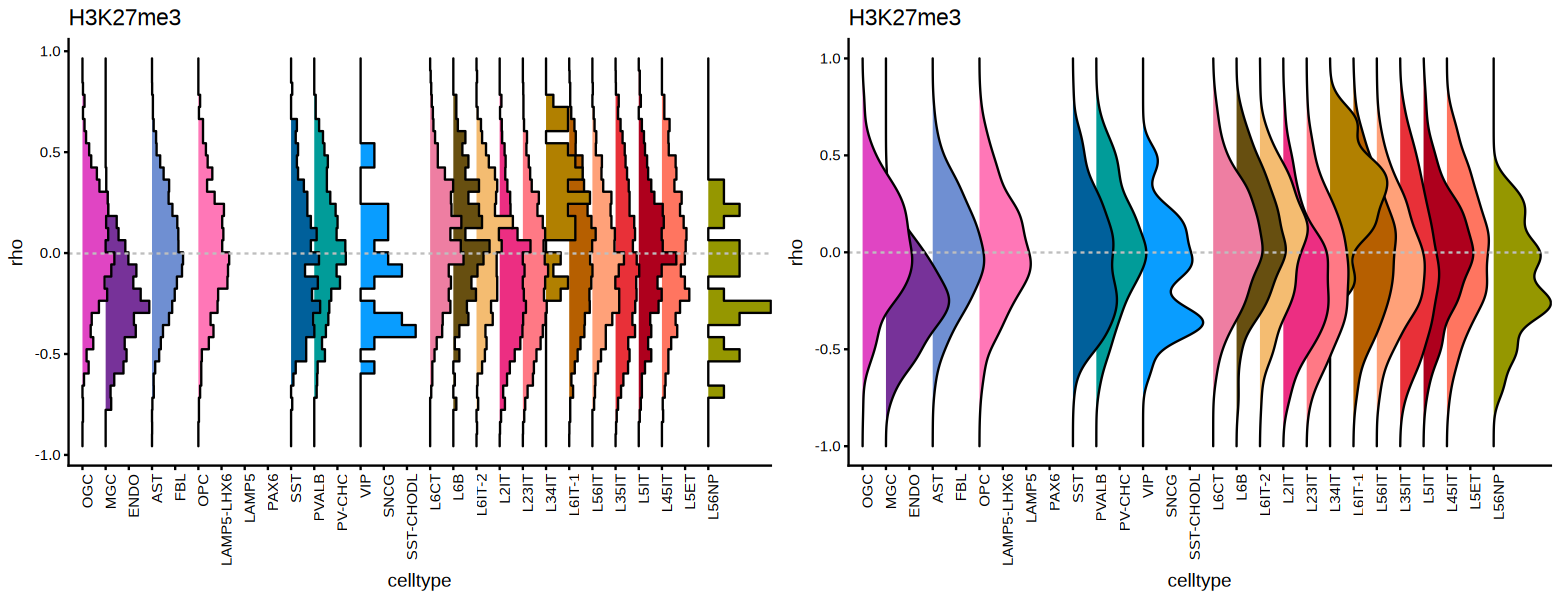

In [936]:
### Drop celltypes with features fewer than 10
t1 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
add_count(celltype) %>% filter(n >= 10) %>%
mutate(celltype = factor(celltype, levels = intersect(corder, torder))) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype, height = ..density..)) + 
geom_density_ridges(stat = "binline") + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27me3") + scale_y_discrete(drop = FALSE) + 
coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

t2 <- do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
add_count(celltype) %>% filter(n >= 10) %>%
mutate(celltype = factor(celltype, levels = intersect(corder, torder))) %>%
ggplot(aes(x = rho, y = celltype, fill = celltype, height = ..density..)) + 
geom_density_ridges(from = -1, to = 1) + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
scale_fill_manual(values = ccol2) + 
theme_classic() + ggtitle("H3K27me3") + scale_y_discrete(drop = FALSE) + 
coord_flip() + 
theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1)) + 
NoLegend()

options(repr.plot.width = 13, repr.plot.height = 5)
fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)

fig1

In [937]:
do.call(rbind, mlist) %>% filter(celltype %in% qclass) %>%
select(celltype) %>% table

celltype
   AST  L23IT   L2IT  L34IT  L35IT  L45IT  L56IT  L56NP   L5IT    L6B   L6CT 
  2695   1745    983     47   2068    855    796     22    330    228    629 
L6IT-1 L6IT-2    MGC    OGC    OPC  PVALB    SST    VIP 
  2043    615    560    669    592    709    296     25 

## Show examples of axis-dependent gene programs

In [1114]:
tmp <- read.table("../Figure/FIG4_cortex_cells_regional_DEG_cor.txt", header = T)
acdorccor <- read.table("../Figure/FIG4_cortex_cells_regional_DEG_ac_DORC_cor.txt", header = T)
medorccor <- read.table("../Figure/FIG4_cortex_cells_regional_DEG_me_DORC_cor.txt", header = T)

In [971]:
## GSEA: use cor as rank to test
suppressPackageStartupMessages(library("fgsea"))
gene_sets_df <- msigdbr::msigdbr(species = 'Homo sapiens', category = 'C5', subcollection = 'GO:BP')
gene_sets <- gene_sets_df %>% split(x = .$gene_symbol, f = .$gs_name)

In [981]:
GSEAres <- list()
for (f in unique(tmp$celltype)){ 
    qdf <- tmp %>% filter(celltype == f, !is.na(pval))
    rankings <- qdf$rho # * -log10(qdf$pval + 10^-5)
    names(rankings) <- qdf$gene
    GSEAres[[f]] <- fgsea(pathways = gene_sets, # List of gene sets to check
                 stats = rankings,
                 scoreType = 'std', # in this case we have both pos and neg rankings. if only pos or neg, set to 'pos', 'neg'
                 minSize = 10,
                 maxSize = 500,
                 nproc = 1) %>% mutate(celltype = f)
}

GSEAres <- do.call(rbind, GSEAres) %>% filter(padj < 0.05) 

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (67.66% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (11.76% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.63% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (87.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (85.27% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (78.17% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (87.28% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (80.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (86.05% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (78.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (47.53% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (82.13% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (77.2% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (83.49% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (83.55% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (81.09% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (48.83% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (33.02% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (57.8% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (69.62% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (39.79% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (20.61% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (36.24% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (74.6% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (39.08% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (69.46% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (10.71% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (62.75% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


  |======================================================================| 100%



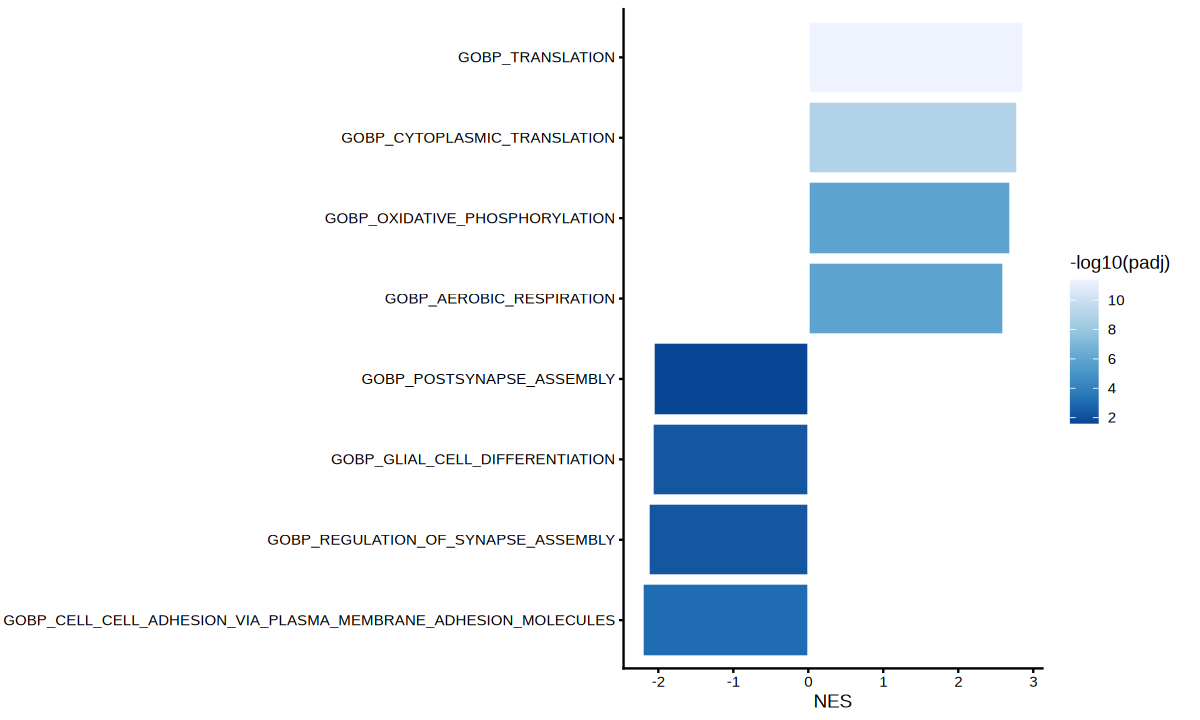

In [1024]:
### example
f <- "L6IT-2"

qpathway1 <- GSEAres %>% filter(celltype == f) %>% slice_min(order_by = NES, n = 4) %>% select(pathway) %>% unlist %>% as.character
qpathway2 <- GSEAres %>% filter(celltype == f) %>% slice_max(order_by = NES, n = 4) %>% select(pathway) %>% unlist %>% as.character

t1 <- GSEAres %>% filter(celltype == f) %>% 
filter(pathway %in% c(qpathway1, qpathway2)) %>%
arrange(NES) %>% 
mutate(pathway = factor(pathway, levels = pathway)) %>%
ggplot(aes(x = NES, y = pathway, fill = -log10(padj))) + 
geom_col(color = "white") + 
theme_classic() + ylab("") + 
scale_fill_distiller()

options(repr.plot.width = 10, repr.plot.height = 6)
t1

## Axis analysis on single cell level

In [16]:
sbcrest <- c('#1e3d57', '#1e5069', '#20647c', '#287b8d', '#36929d', '#4da9aa', '#6abeae', '#8fd3b0', '#bfe8af', '#effab5')

In [114]:
### 1. Use PHATE to calculate transition: https://www.nature.com/articles/s41587-019-0336-3
qmtx <- obj[["RNA"]]$data[qgene,] %>% t
    
library(phateR)
PHATEr <- phate(qmtx)

ERROR: Error in library(phateR): there is no package called ‘phateR’


In [ ]:
tmp <- PHATEr$embedding %>% as.data.frame
tmp$region <- obj@meta.data[rownames(tmp),]$region
tmp$group <- border[match(tmp$region, border$Miniatlas),]$group

options(repr.plot.width = 5, repr.plot.height = 5)
tmp %>% 
ggplot(aes(PHATE1, PHATE2, color = group)) +
geom_point() +
scale_color_distiller() +
theme_classic()

### Doesnt looks good!!

In [124]:
dlist <- list()
for (f in colnames(PHATEr$embedding)){
    dlist[[f]] <- data.frame(pc = f, scc = cor(tmp$group, tmp[, f], method = "spearman"))
}

dlist <- do.call(rbind, dlist) 
dlist %>% arrange(desc(abs(scc))) %>% head(2)

pc     scc      
PHATE2 PHATE2 0.4132422
PHATE1 PHATE1 0.3477763

In [110]:
obj[["RNA"]] <- as(obj[["RNA"]], "Assay")
tmp <- CreateSeuratObject(obj[["RNA"]], meta.data = obj@meta.data)
tmp[["harmony"]] <- CreateDimReducObject(obj@reductions$harmony@cell.embeddings)
tmp <- RunSlingshot(tmp, group.by = "group", reducedDim = "HARMONY", start.clus = "1")

Warning message:
“No assay specified, setting assay as RNA by default.”
Time usage of slingshot: 38.23 mins



Warning message:
“Removed 26735 rows containing missing values or values outside the scale range (`geom_point()`).”


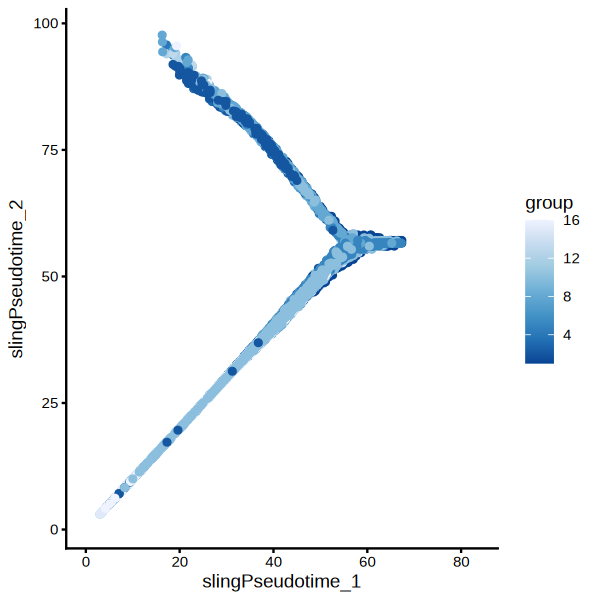

In [117]:
# obj@misc$slingshot <- tmp@misc$slingshot
# sling <- obj@misc$slingshot$HARMONY$SlingPseudotime
merge(as.data.frame(sling), obj@meta.data, by = 0) %>%
ggplot(aes(x = slingPseudotime_1, y = slingPseudotime_2,color = group)) +
geom_point() +
scale_color_distiller() +
theme_classic()

In [119]:
dlist <- list()
for (f in colnames(as.data.frame(sling))){
    dlist[[f]] <- data.frame(pc = f, scc = cor(obj$group, as.data.frame(sling)[, f], method = "spearman", use = "complete.obs"))
}

dlist <- do.call(rbind, dlist) 
dlist %>% arrange(desc(abs(scc))) %>% head(2)

pc                scc       
slingPseudotime_4 slingPseudotime_4 -0.5168924
slingPseudotime_2 slingPseudotime_2 -0.5160777

In [ ]:
qs::qsave(obj, paste0("../04.clustering/02.RNA/04.final_cluster_250722/02.seurat_object/MiniAtlas_RNA_merged_dual_filt_250520_", f, ".region.qs"))

In [13]:
### example calclated using DM
f <- "L6IT-2"
obj <- qs::qread(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/analysis/12.heterogenity/AP_axis/seurat_objects/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_", f, "_RNA.qs"))

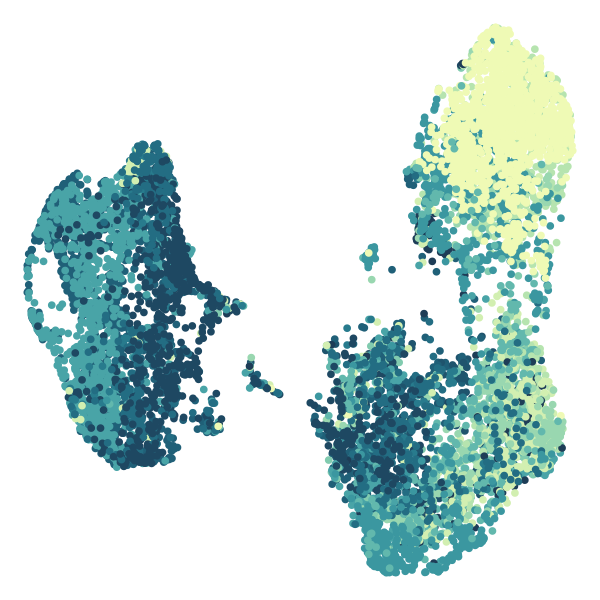

In [22]:
t1 <- merge(obj@meta.data, obj@reductions$umap@cell.embeddings, by = 0) %>% 
ggplot(aes(umap_1, umap_2, color = group)) +
geom_point() +
scale_color_gradientn(colors = sbcrest) + 
theme_void() + NoLegend()

options(repr.plot.width = 5, repr.plot.height = 5)
t1

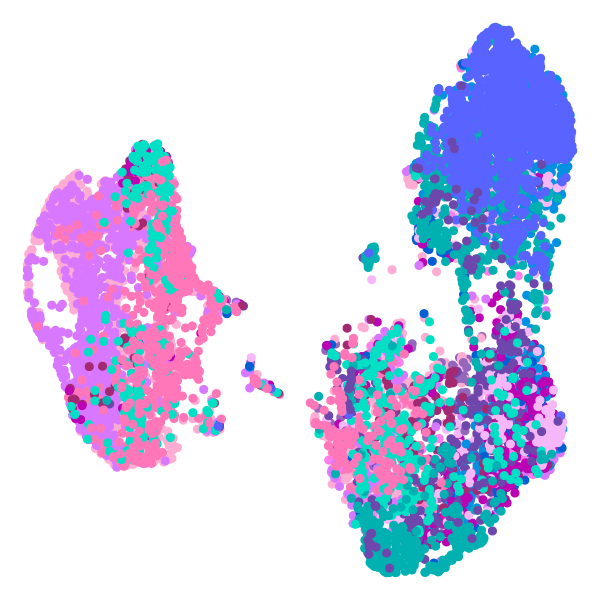

In [77]:
t1 <- merge(obj@meta.data, obj@reductions$umap@cell.embeddings, by = 0) %>% 
ggplot(aes(umap_1, umap_2, color = region)) +
geom_point() +  
scale_color_manual(values = col2) + 
theme_void() + NoLegend()

options(repr.plot.width = 5, repr.plot.height = 5)
t1

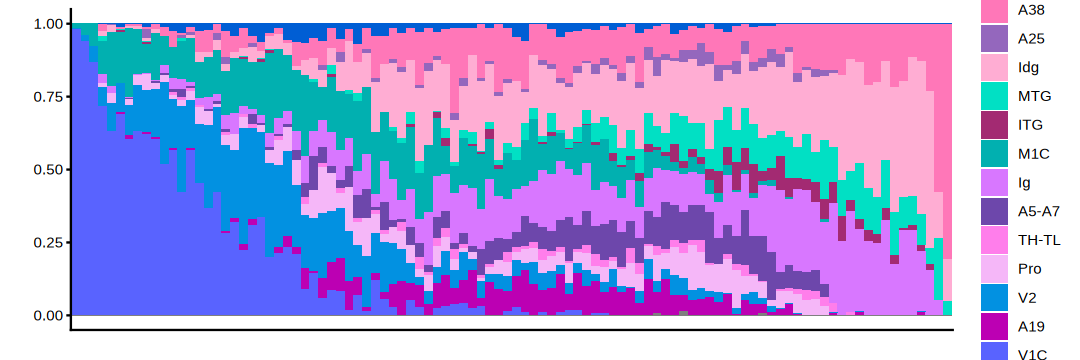

In [80]:
fig1 <- t1$data %>%
mutate(nbins = cut(Pseudotime, breaks = 100, labels = FALSE)) %>%
select(nbins, ident) %>% table %>%
as.data.frame %>% 
mutate(ident = factor(ident, levels = qregion)) %>%
ggplot(aes(x = nbins, y = Freq, fill = ident)) + 
geom_col(position = "fill") + 
theme_classic() + 
theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) + 
xlab("") + ylab("") + scale_fill_manual(values = col2)

fig1

ggsave(fig1, filename = paste0("../Figure/L6IT-2_cortex_cells_axis_pseudotime.pdf"), dpi = 300, height = 2, width = 9)

## Axis-correlated heatmaps along pseudotime

[1] 2779

Warning message:
“package ‘mgcv’ was built under R version 4.4.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:IRanges’:

    collapse


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘rlang’ was built under R version 4.4.3”
Using id as id variables

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


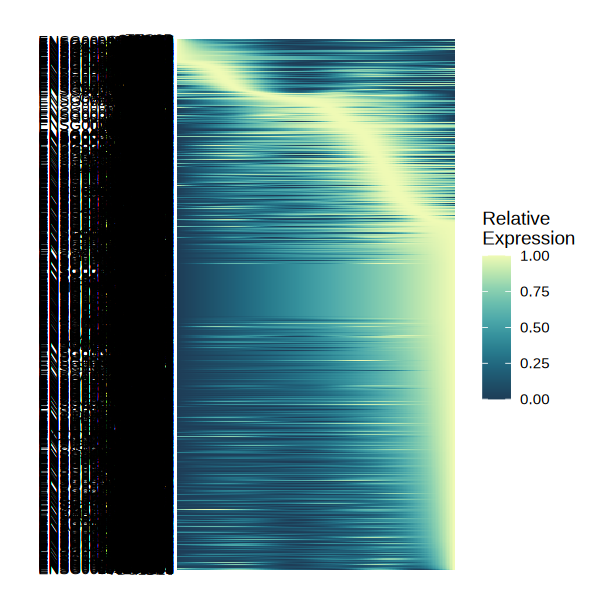

In [39]:
library(SeuratExtend)
tmp <- read.table("../Figure/FIG4_cortex_cells_regional_DEG.txt", row.names = 1, header = T, sep = "\t")
tmp <- tmp %>% mutate(celltype = gsub("([^.]+)\\.([^.]+)", "\\1", rownames(tmp)))
cfgene <- tmp %>% filter(celltype == "L6IT-2", abs(logFC) >= 1, FDR < 0.01) %>% select(gene) %>% unlist %>% as.character %>% unique
cfgene <- intersect(cfgene, rownames(obj))
length(cfgene)

ps <- obj@meta.data[, "Pseudotime", drop = F] %>% mutate(DM = Pseudotime, Entropy = Pseudotime) ### fake name for plot
t1 <- GeneTrendHeatmap.Palantir(obj, features = cfgene,
                                pseudotime.data = ps, magic = FALSE, lineage = "DM") + 
ggtitle("") + scale_fill_gradientn(colors = sbcrest)

options(repr.plot.width = 5, repr.plot.height = 5)
t1                    

In [42]:
### Also plot histone mod: plot enhancer score only
ac <- read_h5ad('../08.conns/DORC/MiniAtlas_broad_abc_filtcelltype_select_conn_250901_subclass_corrected_H3K27ac.L6IT-2.DORC.h5ad')
me3 <- read_h5ad('../08.conns/DORC/MiniAtlas_broad_abc_filtcelltype_select_conn_250901_subclass_corrected_H3K27me3.L6IT-2.DORC.h5ad')

In [45]:
ac <- CreateAssayObject(counts = t(ac$X), meta.data = ac$obs)
ac <- CreateSeuratObject(ac)
me3 <- CreateAssayObject(counts = t(me3$X), meta.data = me3$obs)
me3 <- CreateSeuratObject(me3)

qmeta <- obj@meta.data %>% mutate(dna_bc = paste0(dna, ":", atac_bc))
qcell <- intersect(colnames(ac), qmeta$dna_bc)
ac <- subset(ac, cells = qcell)
ac$Pseudotime <- qmeta[match(colnames(ac), qmeta$dna_bc),]$Pseudotime

qcell <- intersect(colnames(me3), qmeta$dna_bc)
me3 <- subset(me3, cells = qcell)
me3$Pseudotime <- qmeta[match(colnames(me3), qmeta$dna_bc),]$Pseudotime

ac <- NormalizeData(ac)
me3 <- NormalizeData(me3)

Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


In [68]:
ps <- ac@meta.data[, "Pseudotime", drop = F] %>% 
mutate(DM = Pseudotime, Entropy = Pseudotime) ### fake name for plot

### Filter empty genes
qfeature <- intersect(rownames(ac), cfgene)
idx <- which(rowSums(ac[["RNA"]]@counts[qfeature,]) > 0)
qfeature <- qfeature[idx]

t2 <- GeneTrendHeatmap.Palantir(ac, features = qfeature,
                                pseudotime.data = ps, magic = FALSE, lineage = "DM") + 
ggtitle("") + scale_fill_gradientn(colors = sbcrest)

ps <- me3@meta.data[, "Pseudotime", drop = F] %>% 
mutate(DM = Pseudotime, Entropy = Pseudotime) ### fake name for plot

### Filter empty genes
qfeature <- intersect(rownames(me3), cfgene)
idx <- which(rowSums(me3[["RNA"]]@counts[qfeature,]) > 0)
qfeature <- qfeature[idx]

t3 <- GeneTrendHeatmap.Palantir(me3, features = qfeature,
                                pseudotime.data = ps, magic = FALSE, lineage = "DM") + 
ggtitle("") + scale_fill_gradientn(colors = sbcrest)

Using id as id variables

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Using id as id variables

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


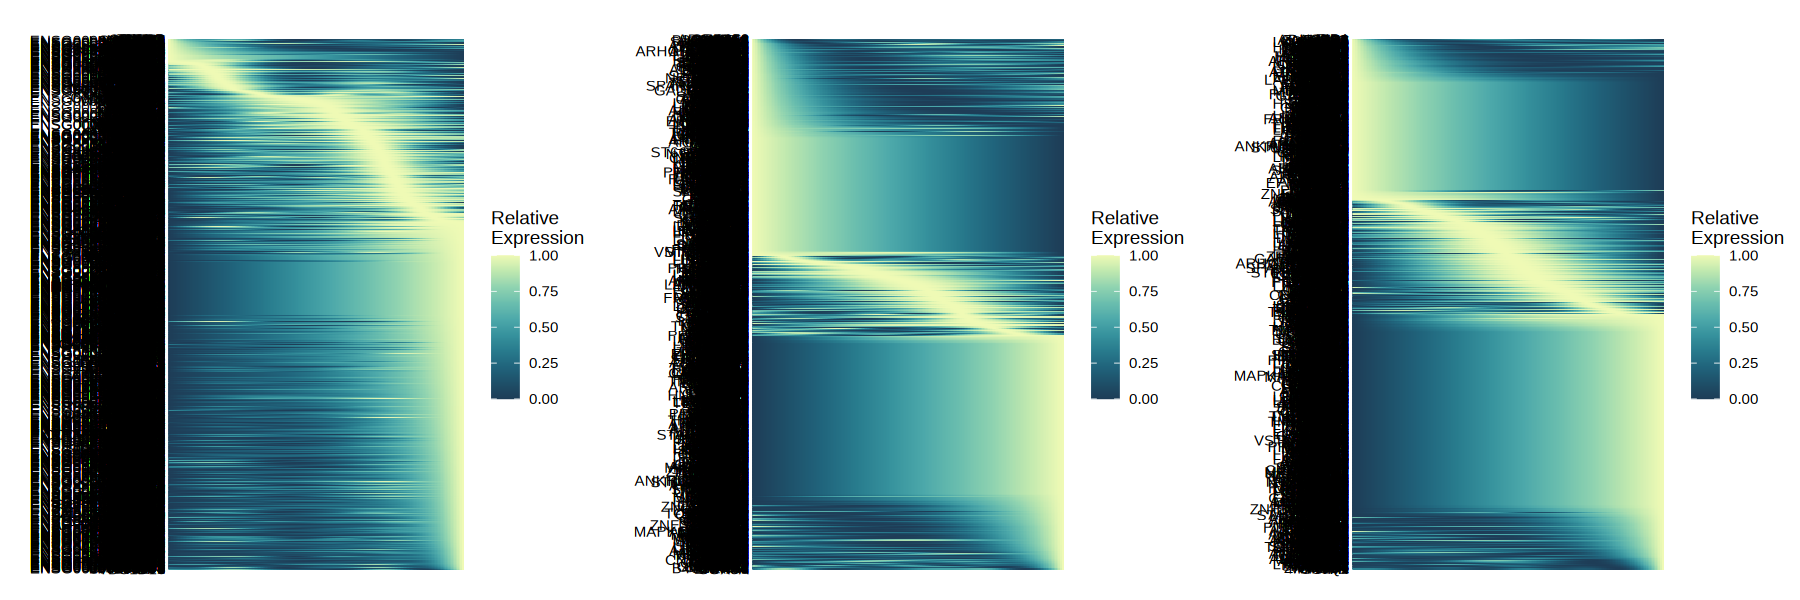

In [69]:
options(repr.plot.width = 15, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

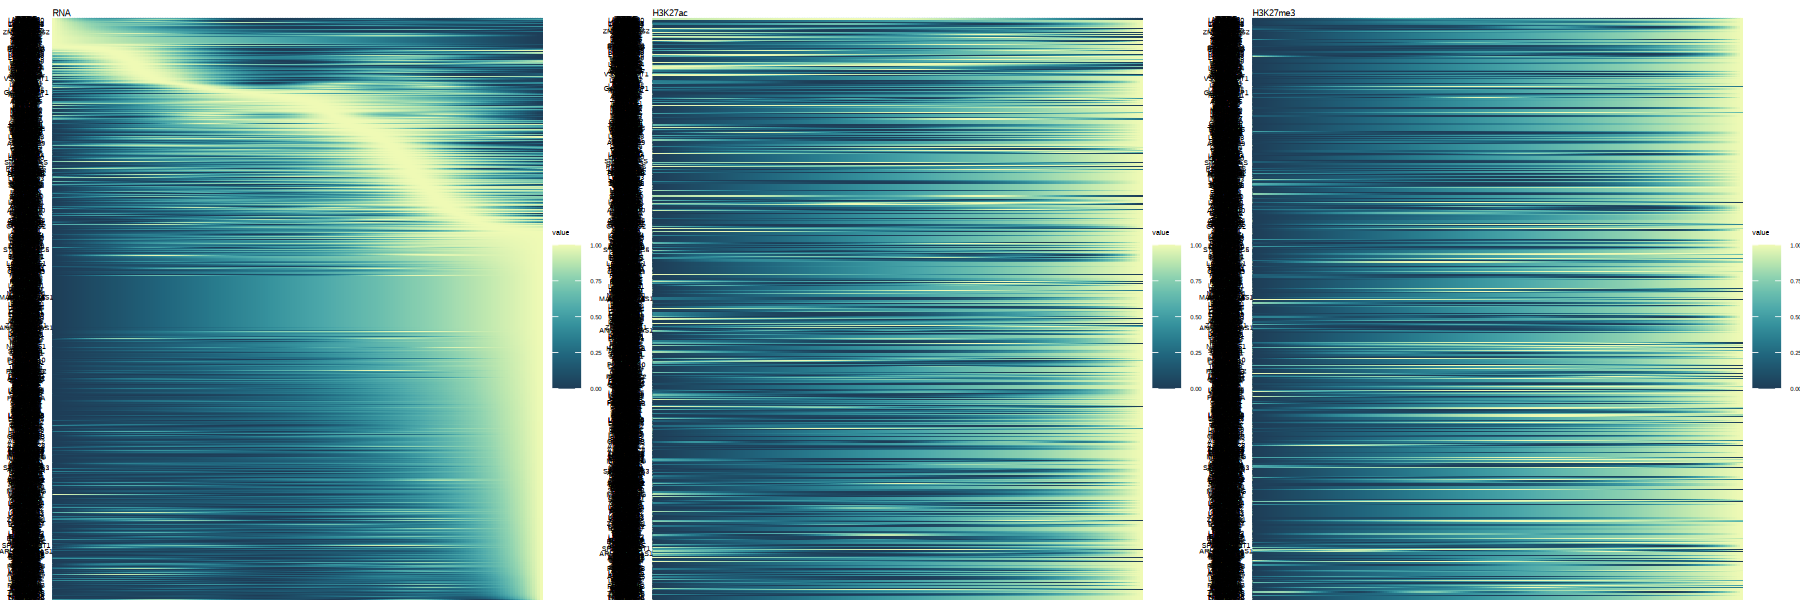

In [73]:
qfeature <- Reduce(intersect, list(t1$data$id, t2$data$id, t3$data$id))

qd <- t1$data %>% filter(id %in% qfeature)
t11 <- qd %>%
ggplot(aes(x = variable, y = id, fill = value)) + 
geom_tile() +
theme_void() + ggtitle("RNA") + theme(axis.text.y = element_text(), text = element_text(size = 4)) + 
scale_fill_gradientn(colors = sbcrest)

t22 <- t2$data %>% 
mutate(id = factor(id, levels = levels(qd$id))) %>%
ggplot(aes(x = variable, y = id, fill = value)) + 
geom_tile() +
theme_void() + ggtitle("H3K27ac") + theme(axis.text.y = element_text(), text = element_text(size = 4)) + 
scale_fill_gradientn(colors = sbcrest)

t33 <- t3$data %>% 
mutate(id = factor(id, levels = levels(qd$id))) %>%
ggplot(aes(x = variable, y = id, fill = value)) + 
geom_tile() +
theme_void() + ggtitle("H3K27me3") + theme(axis.text.y = element_text(), text = element_text(size = 4)) + 
scale_fill_gradientn(colors = sbcrest)

options(repr.plot.width = 15, repr.plot.height = 5)
cowplot::plot_grid(t11, t22, t33, ncol = 3)

In [74]:
d1 <- t11$data %>% mutate(mod = "RNA")
d2 <- t22$data %>% mutate(mod = "H3K27ac")
d3 <- t33$data %>% mutate(mod = "H3K27me3")
df <- do.call(rbind, list(d1, d2, d3))
write.table(df, "../Figure/L6IT-2_cortex_cells_axis_GEX_H3K27ac_H3K27me3_DORC_by_pseudotime.txt", 
            sep = "\t", quote = F, row.names = T, col.names = T)

### Find axis-correlated features to plot

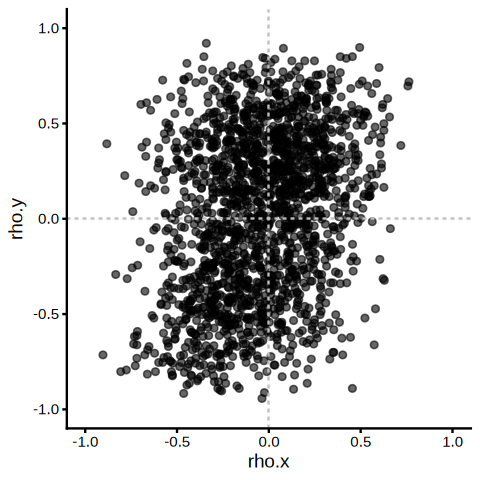

In [102]:
f <- "L6IT-2"

options(repr.plot.width = 6, repr.plot.height = 6)
test1 <- merge(acdorccor[acdorccor$celltype == f,], tmp[tmp$celltype == f,], by = "gene")

options(repr.plot.width = 4, repr.plot.height = 4)
test1 %>%
# filter(gene %in% qqgene$gene) %>%
ggplot(aes(x = rho.x, y = rho.y)) + 
geom_point(alpha = 0.6) + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
geom_hline(yintercept = 0, color = "grey", linetype = 2) + 
xlim(-1, 1) + ylim(-1, 1) + 
theme_classic()

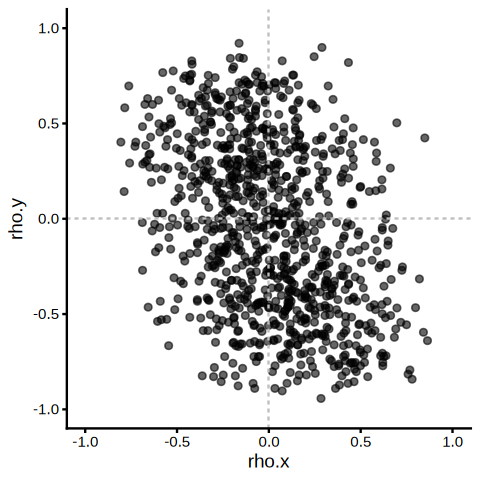

In [103]:
test2 <- merge(medorccor[medorccor$celltype == f,], tmp[tmp$celltype == f,], by = "gene")

options(repr.plot.width = 4, repr.plot.height = 4)
test2 %>%
# filter(gene %in% qqgene$gene) %>%
ggplot(aes(x = rho.x, y = rho.y)) + 
geom_point(alpha = 0.6) + 
geom_vline(xintercept = 0, color = "grey", linetype = 2) + 
geom_hline(yintercept = 0, color = "grey", linetype = 2) + 
xlim(-1, 1) + ylim(-1, 1) + 
theme_classic()

In [104]:
### select genes
gene1 <- test1 %>% filter(rho.x * rho.y > 0.25) %>% select(gene) %>% unlist %>% as.character
gene2 <- test2 %>% filter(rho.x * rho.y < -0.25) %>% select(gene) %>% unlist %>% as.character

qqgene <- tmp %>% 
filter(celltype == f, !is.na(pval)) %>%
filter(gene %in% c(gene1, gene2)) %>% 
arrange(desc(rho))

length(qqgene$gene)

[1] 182

In [139]:
### select pathway
qpathway <- GSEAres %>% filter(celltype == "L6IT-2") %>% slice_min(order_by = NES, n = 2) %>% 
select(pathway) %>% unlist %>% as.character
qpathway

qqqgene <- GSEAres %>% filter(celltype == "L6IT-2", pathway %in% qpathway) %>% 
select(leadingEdge) %>% unlist %>% as.character
qqqgene <- stringr::str_split(qqqgene, pattern = ", ") %>% unlist

[1] "GOBP_CELL_CELL_ADHESION_VIA_PLASMA_MEMBRANE_ADHESION_MOLECULES"
[2] "GOBP_REGULATION_OF_SYNAPSE_ASSEMBLY"

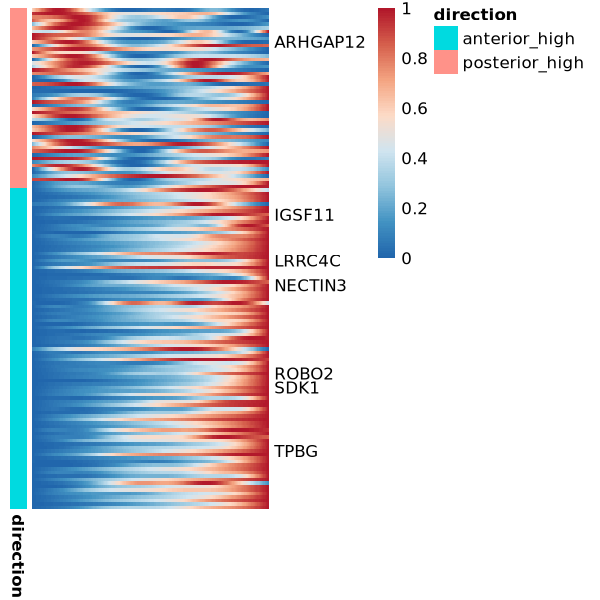

In [155]:
gtp <- qqgene %>% filter(!is.na(me_dorc_cor), !is.na(ac_dorc_cor)) %>% 
mutate(rank = rho+ac_dorc_cor-me_dorc_cor) %>%
arrange(desc(rank)) %>% 
rownames

canno <- qqgene %>% filter(!is.na(me_dorc_cor), !is.na(ac_dorc_cor)) %>% 
select(direction)

mtx <- df %>% filter(mod == "RNA") %>% 
filter(id %in% intersect(df$id, gtp)) %>% 
reshape2::dcast(id ~ variable, value.var = "value") %>%
tibble::column_to_rownames("id")

labelr <- rownames(mtx)
labelr[!(labelr %in% qqqgene)] <- ""

fig1 <- mtx[gtp, ] %>%
pheatmap(cluster_col = F, cluster_row = F, show_colnames = F, show_rownames = T,
         annotation_row = canno, labels_row = labelr, 
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

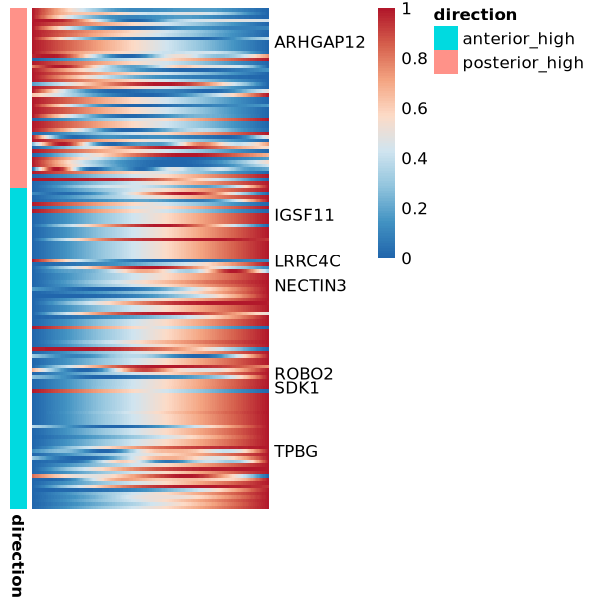

In [156]:
mtx2 <- df %>% filter(mod == "H3K27ac") %>% 
filter(id %in% intersect(df$id, rownames(qqgene))) %>% 
reshape2::dcast(id ~ variable, value.var = "value") %>%
tibble::column_to_rownames("id")

fig2 <- mtx2[gtp, ] %>%
pheatmap(cluster_col = F, cluster_row = F, show_colnames = F, show_rownames = T,
         annotation_row = canno, labels_row = labelr,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

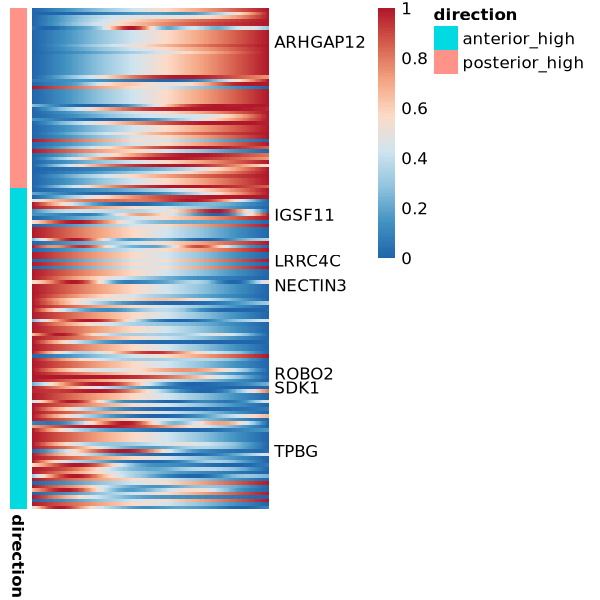

In [157]:
mtx3 <- df %>% filter(mod == "H3K27me3") %>% 
filter(id %in% intersect(df$id, rownames(qqgene))) %>% 
reshape2::dcast(id ~ variable, value.var = "value") %>%
tibble::column_to_rownames("id")

fig3 <- mtx3[gtp, ] %>%
pheatmap(cluster_col = F, cluster_row = F, show_colnames = F, show_rownames = T,
         annotation_row = canno, labels_row = labelr,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(100)))

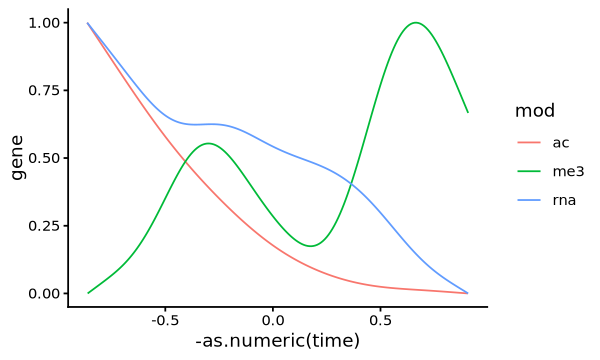

In [205]:
### Plot delta example
qgene1 <- "LRRC4C"
d1 <- mtx[qgene1, ] %>% t %>% as.data.frame %>% tibble::rownames_to_column("time") %>% setNames(c("time", "gene")) %>% mutate(mod = 'rna')
d2 <- mtx2[qgene1, ] %>% t %>% as.data.frame %>% tibble::rownames_to_column("time") %>% setNames(c("time", "gene")) %>% mutate(mod = 'ac')
d3 <- mtx3[qgene1, ] %>% t %>% as.data.frame %>% tibble::rownames_to_column("time") %>% setNames(c("time", "gene")) %>% mutate(mod = 'me3')

options(repr.plot.width = 5, repr.plot.height = 3)
t1 <- do.call(rbind, list(d1, d2, d3)) %>%
ggplot(aes(x = -as.numeric(time), y = gene, color = mod)) + 
geom_line() + 
theme_classic()

t1